# Introduction

In this notebook, A custom encoder decoder neural network architecture is trained on the UW Madison dataset on tumour, to detect and map out tumour regions in MRI scans. 

# Tools

In [1]:
! pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as tv_models
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, torch, tqdm, os, torchvision, gc, warnings, random
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torch.utils.data import Dataset, DataLoader
from monai.metrics import compute_hausdorff_distance

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.autograd.set_detect_anomaly(True)

# Data Exploration Prior to Transformation

[Details on data specification](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/data)



In [3]:
data_df_path = '../input/uw-madison-gi-tract-image-segmentation/train.csv'
data_df = pd.read_csv(data_df_path)
data_df.head()

id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN

Each datasample (slice) has three classes of mask label; large bowel, small bowel and stomach. The mask segment for each of the classes is stored in the csv metadata as an RLE (Running Length Encoded) string.

It is observed that there are missing values in the csv meta data. The missing values correspond to image samples that do not have tumour present for that particular class. Each unique ID corresponds to a given sample image in the dataset and is repeated 3 times in the csv metadata, each for the 3 given classes

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [5]:
unique_ids = data_df['id'].unique()

print(f'number of unique IDs {len(unique_ids)}')

number of unique IDs 38496


The csv metadata comprises 115,488 rows and 38,496 unique IDs, each ID for each image sample

In the code cell below, the function converts the csv metadata from long to wide such that each row corresponds to a single unique ID

In [6]:
def long_to_wide(df):
    df = df.pivot(index='id', columns='class', values='segmentation')
    df['id'] = df.index
    df.index = [i for i in range(len(df))]
    return df

data_df = long_to_wide(data_df)
data_df.head()

class large_bowel small_bowel stomach                        id
0             NaN         NaN     NaN  case101_day20_slice_0001
1             NaN         NaN     NaN  case101_day20_slice_0002
2             NaN         NaN     NaN  case101_day20_slice_0003
3             NaN         NaN     NaN  case101_day20_slice_0004
4             NaN         NaN     NaN  case101_day20_slice_0005

In [7]:
print(f'number of unique IDs {len(data_df)}')

number of unique IDs 38496


String manipulation is done on the path string of each image sample to extract relevant information concerning a given sample to store on the ```data_df``` dataframe

In [8]:
def get_info_from_path(path):
    case_day, filname = path.rsplit("/", maxsplit=3)[1::2]
    case, day = case_day.split('_')
    case_slice = filname.split('_')[0:2]
    case_slice = '_'.join(case_slice)
    img_id = '_'.join([case_day, case_slice])

    case = case.replace('case', '')
    day = day.replace('day', '')
    slice_no, width, height = filname.split('_')[1:4]
    
    return img_id, case, day, slice_no, width, height


def get_file_names(root_path: str, ext='.png'):
    image_paths = []
    image_properties = []
    for path, subdirs, files in tqdm.tqdm(os.walk(root_path)):
        for name in files:
            img_path = os.path.join(path, name)
            image_paths.append(img_path)
            properties = list(get_info_from_path(img_path))
            image_properties.append(properties)
                        
    return image_paths, image_properties

training_data_path = '../input/uw-madison-gi-tract-image-segmentation/train'
image_paths, image_properties = get_file_names(training_data_path)

634it [00:05, 121.98it/s]


In [9]:
image_properties = np.array(image_properties)

img_df = pd.DataFrame()

img_df['id'] = image_properties[:, 0]
img_df['case'] = image_properties[:, 1].astype(int)
img_df['day'] = image_properties[:, 2].astype(int)
img_df['slice'] = image_properties[:, 3].astype(int)
img_df['width'] = image_properties[:, 4].astype(int)
img_df['height'] = image_properties[:, 5].astype(int)
img_df['path'] = image_paths

img_df.head()

id  case  day  slice  width  height  \
0  case36_day14_slice_0006    36   14      6    266     266   
1  case36_day14_slice_0082    36   14     82    266     266   
2  case36_day14_slice_0113    36   14    113    266     266   
3  case36_day14_slice_0076    36   14     76    266     266   
4  case36_day14_slice_0125    36   14    125    266     266   

                                                path  
0  ../input/uw-madison-gi-tract-image-segmentatio...  
1  ../input/uw-madison-gi-tract-image-segmentatio...  
2  ../input/uw-madison-gi-tract-image-segmentatio...  
3  ../input/uw-madison-gi-tract-image-segmentatio...  
4  ../input/uw-madison-gi-tract-image-segmentatio...

In [10]:
data_df = data_df.merge(img_df, on='id', how='outer')
id_column = data_df.pop('id')
data_df.insert(0, 'id', id_column)

data_df.head()

id large_bowel small_bowel stomach  case  day  slice  \
0  case101_day20_slice_0001         NaN         NaN     NaN   101   20      1   
1  case101_day20_slice_0002         NaN         NaN     NaN   101   20      2   
2  case101_day20_slice_0003         NaN         NaN     NaN   101   20      3   
3  case101_day20_slice_0004         NaN         NaN     NaN   101   20      4   
4  case101_day20_slice_0005         NaN         NaN     NaN   101   20      5   

   width  height                                               path  
0    266     266  ../input/uw-madison-gi-tract-image-segmentatio...  
1    266     266  ../input/uw-madison-gi-tract-image-segmentatio...  
2    266     266  ../input/uw-madison-gi-tract-image-segmentatio...  
3    266     266  ../input/uw-madison-gi-tract-image-segmentatio...  
4    266     266  ../input/uw-madison-gi-tract-image-segmentatio...

Total number of patient cases is gotten from the finished dataframe in the code cell below

In [11]:
cases = data_df['case'].unique()
            
print(f"Number of Cases: {len(cases)}")

Number of Cases: 85


The cell below gets the average number of slices (datasamples) per case

In [12]:
n_slices = 0
for case in cases:
    case_slice = data_df.loc[data_df['case'] == case]['slice'].unique()
    n_slices += len(case_slice)
    
average_slices_per_case = n_slices // len(cases)

print(f'avarage number of slices per case is {average_slices_per_case}')

avarage number of slices per case is 143


The RLEs for large bowel, small bowel and stomach of a single sample is retrieved and logged to the output cell of the code cell below

In [13]:
lb_seg = data_df.large_bowel[94]
sb_seg = data_df.small_bowel[94]
stomach_seg = data_df.stomach[94]

print(
    f'tumor on large bowel mask\n: {lb_seg} \n\n', 
    f'tumor on small bowel mask\n: {sb_seg} \n\n',
    f'tumor on stomach mask\n: {stomach_seg} \n\n')

tumor on large bowel mask
: 24153 7 24417 11 24682 14 24948 14 25213 16 25479 17 25744 19 26009 21 26275 21 26540 23 26805 24 27071 24 27337 24 27603 24 27869 23 28135 23 28401 23 28667 22 28934 20 29052 6 29201 17 29317 9 29468 13 29582 11 29735 9 29848 11 30002 6 30114 12 30380 12 30544 14 30646 13 30809 16 30912 13 31074 18 31178 14 31339 19 31444 14 31605 19 31710 14 31871 20 31976 14 32137 20 32242 15 32403 19 32507 16 32669 19 32773 16 32935 19 33039 16 33201 19 33304 17 33467 19 33570 17 33734 18 33836 17 34001 17 34101 18 34268 15 34367 19 34536 13 34633 19 34803 11 34898 20 35071 9 35163 21 35338 7 35429 21 35694 22 35960 22 36225 22 36491 22 36755 24 37020 25 37286 24 37551 24 37816 25 38082 24 38347 24 38613 23 38879 23 39145 22 39411 22 39677 21 39943 21 40209 20 40476 18 40742 18 41008 17 41275 15 41541 15 41808 13 42075 11 42343 7 

 tumor on small bowel mask
: 26184 4 26449 7 26715 8 26980 11 27245 14 27510 19 27775 21 28041 21 28306 21 28571 21 28837 19 29103 18 29368 1

In the cell below, a function is made for converting the RLEs to mask segments. This function assigns pixel values of 1 where tumour segment is present and 0 to every other place. 

In [14]:
def rle2mask(img_shape, rle):
    #correct order: (H, W)
    H, W = img_shape
    
    rle = rle.split()
    start_idx, lengths = np.array(rle[0::2], dtype=int), np.array(rle[1::2], dtype=int)
    end_idx = start_idx + (lengths - 1)
    
    mask = np.zeros(H*W, dtype=np.int8)

    for start, end in zip(start_idx, end_idx):
        mask[start:end] = 1

    mask = mask.reshape(H, W)
    return mask


idx = 90
sample_path = data_df.path[idx]
lb_seg = data_df.large_bowel[idx]
sb_seg = data_df.small_bowel[idx]
stomach_seg = data_df.stomach[idx]

sample_img = cv2.imread(sample_path, cv2.IMREAD_UNCHANGED)
img_shape = sample_img.shape

lb_seg_mask = rle2mask(img_shape, lb_seg)
sb_seg_mask = rle2mask(img_shape, sb_seg)
stomach_seg_mask = rle2mask(img_shape, stomach_seg)

The sample image and the corresponding masks are plotted for visualisation.

Text(0.5, 1.0, 'stomach tumour mask')

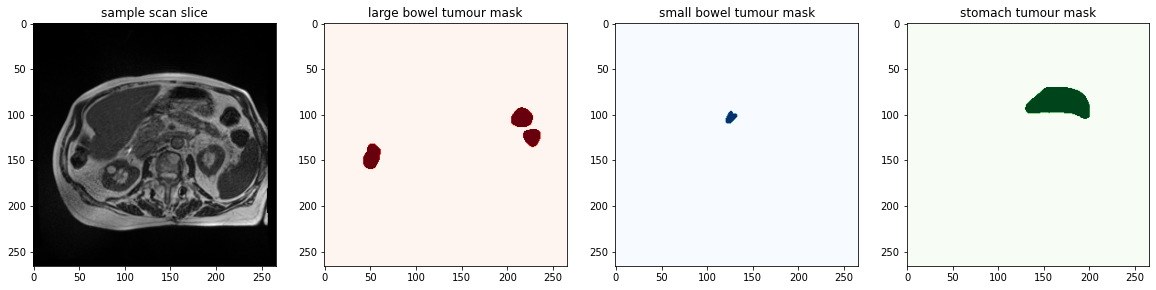

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

axs[0].imshow(sample_img, cmap='gray')
axs[0].set_title('sample scan slice')

axs[1].imshow(lb_seg_mask, cmap='Reds')
axs[1].set_title('large bowel tumour mask')

axs[2].imshow(sb_seg_mask, cmap='Blues')
axs[2].set_title('small bowel tumour mask')

axs[3].imshow(stomach_seg_mask, cmap='Greens')
axs[3].set_title('stomach tumour mask')

Text(0.5, 1.0, 'combined tumour masks')

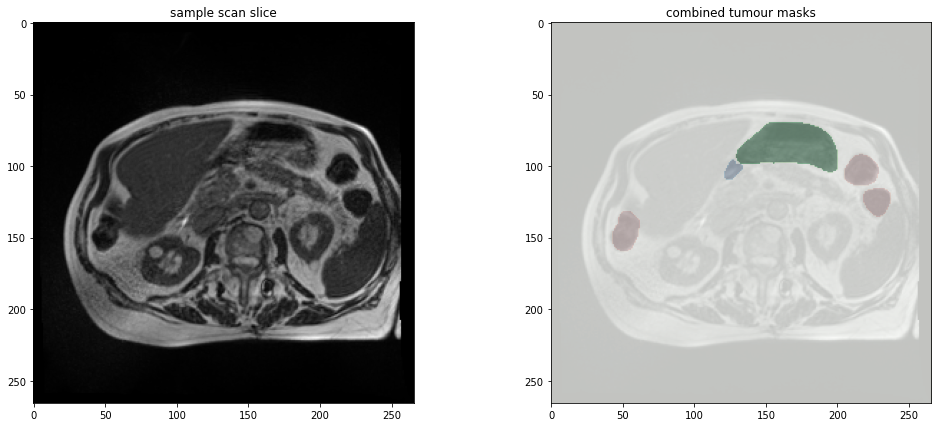

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

axs[0].imshow(sample_img, cmap='gray')
axs[0].set_title('sample scan slice')

alpha = 0.4
axs[1].imshow(sample_img, cmap='gray')
axs[1].imshow(lb_seg_mask, cmap='Reds', alpha=alpha)
axs[1].imshow(sb_seg_mask, cmap='Blues', alpha=alpha)
axs[1].imshow(stomach_seg_mask, cmap='Greens', alpha=alpha)
axs[1].set_title('combined tumour masks')

Next, the dataframe is shuffled

In [17]:
data_df = data_df.sample(frac=1)
data_df.index = [i for i in range(len(data_df))]
data_df.head()

id  \
0  case156_day10_slice_0116   
1   case41_day25_slice_0026   
2  case122_day27_slice_0030   
3   case20_day22_slice_0143   
4    case77_day0_slice_0057   

                                         large_bowel  \
0  21731 4 21995 8 22260 10 22525 12 22791 12 230...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         small_bowel  \
0  24929 5 25193 8 25458 10 25723 12 25989 14 262...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             stomach  case  day  slice  width  \
0  18754 16 19018 21 19283 24 19548 27 19813 30 2...   156   10    116    266   
1                                                NaN    41   25     26    266   
2                                                NaN   122   27     30    266   
3                                                NaN    20   22    143    266   
4                                                NaN    77    0     57    266   

   height                                               path  
0     266  ../input/uw-madison-gi-tract-image-segmentatio...  
1     266  ../input/uw-madison-gi-tract-image-segmentatio...  
2     266  ../input/uw-madison-gi-tract-image-segmentatio...  
3     266  ../input/uw-madison-gi-tract-image-segmentatio...  
4     266  ../input/uw-madison-gi-tract-image-segmentatio...

The function below adds an `is_empty` column to the dataframe, and assigns a b0olean value of `True` to any row with no RLE on any of the three classes. 

In [18]:
def check_empty(df):
    df['is_empty'] = False
    if pd.isna(df.large_bowel) and pd.isna(df.large_bowel) and pd.isna(df.stomach):
        df['is_empty'] = True
    return df

data_df = data_df.apply(check_empty, axis=1)
data_df.head()

id  \
0  case156_day10_slice_0116   
1   case41_day25_slice_0026   
2  case122_day27_slice_0030   
3   case20_day22_slice_0143   
4    case77_day0_slice_0057   

                                         large_bowel  \
0  21731 4 21995 8 22260 10 22525 12 22791 12 230...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         small_bowel  \
0  24929 5 25193 8 25458 10 25723 12 25989 14 262...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             stomach  case  day  slice  width  \
0  18754 16 19018 21 19283 24 19548 27 19813 30 2...   156   10    116    266   
1                                                NaN    41   25     26    266   
2                                                NaN   122   27     30    266   
3                                                NaN    20   22    143    266   
4                                                NaN    77    0     57    266   

   height                                               path  is_empty  
0     266  ../input/uw-madison-gi-tract-image-segmentatio...     False  
1     266  ../input/uw-madison-gi-tract-image-segmentatio...      True  
2     266  ../input/uw-madison-gi-tract-image-segmentatio...      True  
3     266  ../input/uw-madison-gi-tract-image-segmentatio...      True  
4     266  ../input/uw-madison-gi-tract-image-segmentatio...      True

[Information on the discussion](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/319963) section of the dataset insinuated that the days some cases had masks that did not align with their corresponding samples, so in the cell below, they are pruned out from the dataframe

In [19]:
#remove bad data
to_drop = data_df[(data_df['case'] == 7) & (data_df['day'] == 0)].index
data_df.drop(to_drop, inplace=True)

to_drop = data_df[(data_df['case'] == 81) & (data_df['day'] == 30)].index
data_df.drop(to_drop, inplace=True)

print(len(data_df))

data_df.index = [i for i in range(len(data_df))]
data_df.head()

38208


id  \
0  case156_day10_slice_0116   
1   case41_day25_slice_0026   
2  case122_day27_slice_0030   
3   case20_day22_slice_0143   
4    case77_day0_slice_0057   

                                         large_bowel  \
0  21731 4 21995 8 22260 10 22525 12 22791 12 230...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         small_bowel  \
0  24929 5 25193 8 25458 10 25723 12 25989 14 262...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             stomach  case  day  slice  width  \
0  18754 16 19018 21 19283 24 19548 27 19813 30 2...   156   10    116    266   
1                                                NaN    41   25     26    266   
2                                                NaN   122   27     30    266   
3                                                NaN    20   22    143    266   
4                                                NaN    77    0     57    266   

   height                                               path  is_empty  
0     266  ../input/uw-madison-gi-tract-image-segmentatio...     False  
1     266  ../input/uw-madison-gi-tract-image-segmentatio...      True  
2     266  ../input/uw-madison-gi-tract-image-segmentatio...      True  
3     266  ../input/uw-madison-gi-tract-image-segmentatio...      True  
4     266  ../input/uw-madison-gi-tract-image-segmentatio...      True

The bar chart below compares the frequency of samples with RLE in any of the 3 classes to samples with atleast 1 RLE.

Text(0.5, 1.0, 'count plot of number of samples with empty mask')

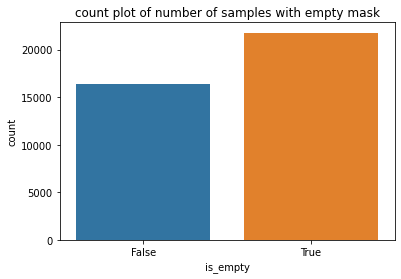

In [20]:
sns.countplot(x ='is_empty', data = data_df)
plt.title('count plot of number of samples with empty mask')

The plot above insinuates that more than 20,000 samples do not have tumour present in them.

The entire dataset consumes over 2GB of memory on disk, hence the dataset is loaded to RAM for eager retrieval of samples in the dataset class as opposed to lazy retrieval, so as to avoid I/O overhead during training. Each sample path is referenced from the dataframe, retrieved and appended into a list container upon iteration.

In [21]:
def get_images(paths):
    images = []
    for img_path in tqdm.tqdm(paths):
        sample_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        images.append(sample_img)
        
    return images
        
loaded_images = get_images(data_df.path)

100%|██████████| 38208/38208 [07:15<00:00, 87.78it/s]


In [22]:
len(loaded_images)

38208

In total there are now 38,208 datasamples.

# Data Transformation Pipeline

The following augmentation techniques are chained together to makeup the transformation pipeline:

1. Random resized crop.
2. Random rotation.
3. Random flip.
4. Random gaussian blur.
5. Random noise addition.


The noise addition pipeline is a subpipeline in the transformation pipeline. 4 types of noise were utilised for data augmentation in this implmentation, the gaussian noise, speckle noise, salt and pepper noise and the poisson noise. 

The pipeline is designed such that for each instance call, the augmentation techniques that make up the pipeline are shuffled in position.

In [23]:
class Noise:
    
    @staticmethod
    def apply_gaussian(image, mean=0, std=1):
        noise = torch.normal(mean=mean, std=std, size=image.shape)
        image = image + noise
        return image

    @staticmethod
    def apply_speckle(image, mean=0, std=1):
        noise = torch.normal(mean=mean, std=std, size=image.shape)
        speckle = image * noise
        image = image + speckle
        return image


    @staticmethod
    def apply_salt_and_pepper(image, n_pixels=500):
        _, H, W = image.shape

        for op in ['salt', 'pepper']:
            val = image.max()
            if op == 'pepper':val = 0
            
            for i in range(n_pixels):
                x_coord = random.randint(0, W-1)
                y_coord = random.randint(0, H-1)
                image[:, y_coord, x_coord] = val
        return image
        
    @staticmethod
    def apply_poisson(image, rate=5):
        noise = torch.rand(*image.shape) * rate
        noise = torch.poisson(noise)
        image = image + noise
        return image


class FirstChannelRandomGaussianBlur(object):
    def __init__(self, p, kernel_size=(3, 9), sigma=(0.1, 11)):
        self.p = p
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=self.kernel_size, sigma=self.sigma)

    def __call__(self, sample):
        #input shape: (4, H, W)
        if self.p < random.random():return sample

        image, mask = sample[0].unsqueeze(dim=0), sample[1:]
        image = self.gaussian_blur(image)
        sample = torch.cat((image, mask), dim=0)
        return sample


class FirstChannelRandomNoise(object):
    def __init__(self, p=0.5, **kwargs):
        defaultKwargs = {
            'mean_range':(0, 10),
            'std_range':(1, 5),
            'sp_px_range':(300, 1000),
            'poisson_rate_range':(5, 50)}
        
        self.p = p
        self.kwargs = {**defaultKwargs, **kwargs}
        self.ops = ('gaussian', 'speckle', 'salt_&_pepper', 'poisson')

    def __call__(self, sample):
        if self.p < random.random():return sample

        image, mask = sample[0].unsqueeze(dim=0), sample[1:]
        op = random.choice(self.ops)
        if op == 'gaussian':
            mean = random.randint(*self.kwargs['mean_range'])
            std = random.randint(*self.kwargs['std_range'])
            image = Noise.apply_gaussian(image, mean, std)

        elif op == 'speckle':
            mean = random.randint(*self.kwargs['mean_range'])
            std = random.randint(*self.kwargs['std_range'])
            image = Noise.apply_speckle(image, mean, std)

        elif op == 'salt_&_pepper':
            n_pixels = random.randint(*self.kwargs['sp_px_range'])
            image = Noise.apply_salt_and_pepper(image, n_pixels)

        elif op == 'poisson':
            rate = random.randint(*self.kwargs['poisson_rate_range'])
            image = Noise.apply_poisson(image, rate)

        sample = torch.cat((image, mask), dim=0)
        return sample

        
class CustomRandomRotation(object):
    def __init__(self, p, angle_range=(0, 360)):
        self.p = p
        self.angle_range = angle_range
        self.random_rotation = transforms.RandomRotation(self.angle_range)

    def __call__(self, sample):
        #input shape: (C, H, W)
        if self.p < random.random():return sample

        sample = self.random_rotation(sample)
        return sample

    
class CustomRandomResizedCrop(object):
    def __init__(self, p, scale=(0.5, 1.0)):
        self.p = p
        self.scale = scale

    def __call__(self, sample):
        #input shape: (C, H, W)
        if self.p < random.random():return sample

        _, H, W = sample.shape
        random_resizedcrop = transforms.RandomResizedCrop(
            (H, W), scale=self.scale, interpolation=transforms.InterpolationMode.NEAREST)
        sample = random_resizedcrop(sample)
        return sample


class CustomCompose(transforms.Compose):
    def __init__(self, transforms, shuffle=False):
        super(CustomCompose, self).__init__(transforms)
        self.transforms = transforms
        self.shuffle = shuffle

    def __call__(self, image):
        transforms = self.transforms
        if self.shuffle:
            transforms = random.sample(self.transforms, len(self.transforms))
            
        for T in transforms:
            image = T(image)
        return image


def image_resize(image, size):
    #image shape: C, H, W or N, C, H, W
    H, W = size
    assert len(image.shape) == 3 or len(image.shape) == 4, \
     'input image must be of shape  C, H, W or N, C, H, W'

    if isinstance(image, np.ndarray): image = torch.from_numpy(image) 
    res_model = transforms.Resize((H, W), interpolation=transforms.InterpolationMode.NEAREST)
    image = res_model(image)
    return image


def image_normalize(image):
    image = image.max() - image
    image = image - image.min()
    image = image / image.max()
    return image    


def data_augmentation(**kwargs):

    defaultKwargs = {
        'shuffle_tranforms':True,
        'crop_p':0.5, 
        'rotation_p':0.5, 
        'Hflip_p':0.5, 
        'Vflip_p':0.5, 
        'blur_p':0.5,
        'noise_p':0.5,
        'rotation_angle_range':(-30, 30),
        'crop_scale':(0.7, 1.0),
        'blur_kernel_size':(3, 5),
        'blur_sigma':(0.1, 5),
        }

    kwargs = {**defaultKwargs, **kwargs}

    transform_list = [
        CustomRandomResizedCrop(p=kwargs['crop_p'], scale=kwargs['crop_scale']),
        CustomRandomRotation(p=kwargs['rotation_p'], angle_range=kwargs['rotation_angle_range']),
        transforms.RandomHorizontalFlip(kwargs['Hflip_p']),
        transforms.RandomVerticalFlip(kwargs['Vflip_p']),
        FirstChannelRandomGaussianBlur(kwargs['blur_p'], kernel_size=kwargs['blur_kernel_size'], sigma=kwargs['blur_sigma']),
        FirstChannelRandomNoise(p=kwargs['noise_p'])
    ]
    T = CustomCompose(transform_list, shuffle=kwargs['shuffle_tranforms'])
    return T


data_transforms = data_augmentation()

# Dataset Class

The dataset class is implemented next, it takes 6 positional arguments; the list of images, the corresponding meta data (a dataframe), an instance of the transformer pipeline, the probability of transformation (`tp`), the size of image and finally the size of corresponding target mask.

Upon retrieval of a given image sample, the corresponding RLEs are retrieved from the dataframe and are converted to mask segments via the `rle2mask` method. The image and masks are then stacked together to form a single sample with 4 channels, This stacked sample is passed into the data transformation pipeline for the necessary data augmentation if called. The transformation pipeline is called in the dataset class $m$ times for every $n$ data sample retrieval via the dataset class instance, where $m = t_p * n$; and $t_p$ is the probability value of data transformation.

The stacked matrices are then split into sample image and corresponding masks, the pixel values of the sample image are then normalised to values within the range of 0 and 1. Finally both sample images and target masks are reshaped to the image and target mask size respectively. In this implementation, the images and masks are reshaped to 224 x 224. 

The target masks of a corresponding image sample is stacked together such that it is a single image with 3 color channels, whereas the sample image comprises a single channel.

In [24]:
class ImageDataset(Dataset):
    def __init__(self, images, images_df, transform=None, 
                 tp=0.5, input_size=(224, 224), target_size=(224, 224)):
      
        self.images = images
        self.images_df = images_df
        self.transform = transform
        self.tp = tp
        self.input_size = input_size
        self.target_size = target_size
        
        
    def __len__(self):
        return len(self.images_df)
    
       
    def __getitem__(self, idx:int):
        image = self.images[idx]
        image = np.expand_dims(image, axis=0).astype('int32')

        original_H, original_W = image.shape[1:]
        
        lb_seg_mask = self.rle2mask(image.shape[1:], self.images_df.large_bowel[idx])
        sb_seg_mask = self.rle2mask(image.shape[1:], self.images_df.small_bowel[idx])
        stomach_seg_mask = self.rle2mask(image.shape[1:], self.images_df.stomach[idx])
        
        gt_mask = np.stack((lb_seg_mask, sb_seg_mask, stomach_seg_mask), axis=0).astype('int32')

        if self.transform:
            randn = random.random()
            if randn < self.tp:
                aug = self.transform(
                    torch.from_numpy(
                        np.concatenate((image, gt_mask), axis=0)
                    ))
                image, gt_mask = aug[0].unsqueeze(dim=0), aug[1:]

        image = image_resize(image, self.input_size).type(torch.float32) #shape: (1, H, W)
        gt_mask = image_resize(gt_mask, self.target_size).type(torch.float32) #shape: (3, H, W)
        image = image_normalize(image)

        return image, gt_mask
    

    def rle2mask(self, img_shape, rle:str):
        #correct order: (H, W)
        H, W = img_shape
        if pd.isnull(rle): return np.zeros((H, W), dtype=np.int8)
        
        rle = rle.split()
        start_idx, lengths = np.array(rle[0::2], dtype=int), np.array(rle[1::2], dtype=int)
        end_idx = start_idx + (lengths - 1)

        mask = np.zeros(H*W, dtype=np.int8)
        for start, end in zip(start_idx, end_idx):
            mask[start:end] = 1

        mask = mask.reshape(H, W)
        return mask

Next, an object of the dataset class is instantiated and few transformed samples are visualised in the cell below

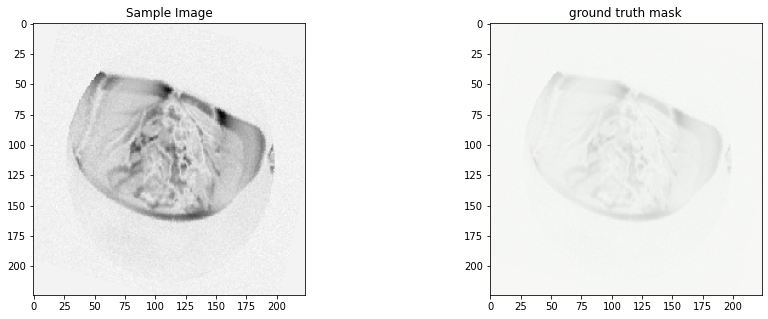

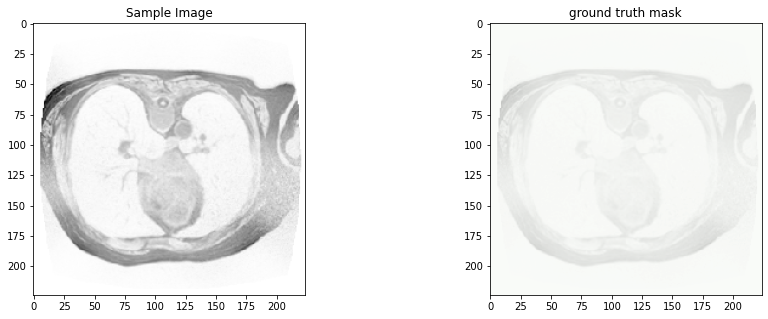

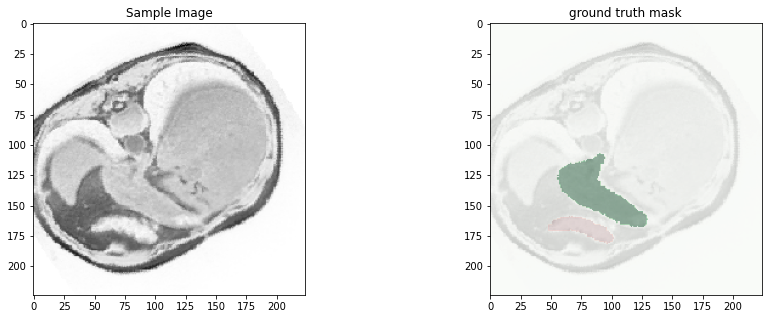

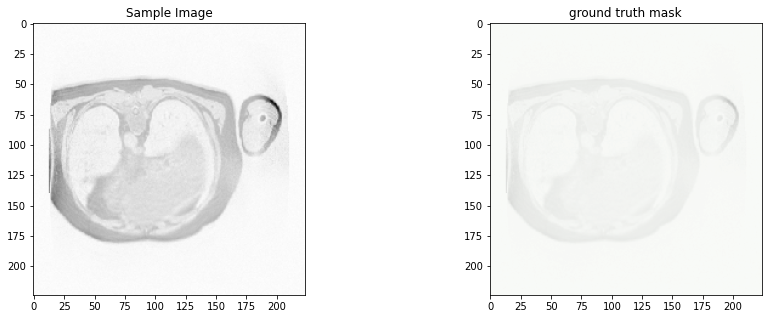

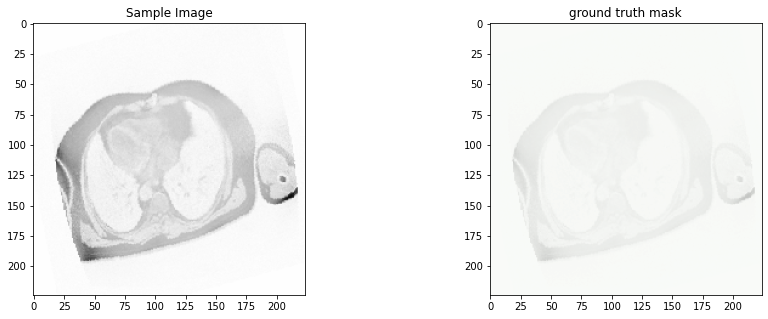

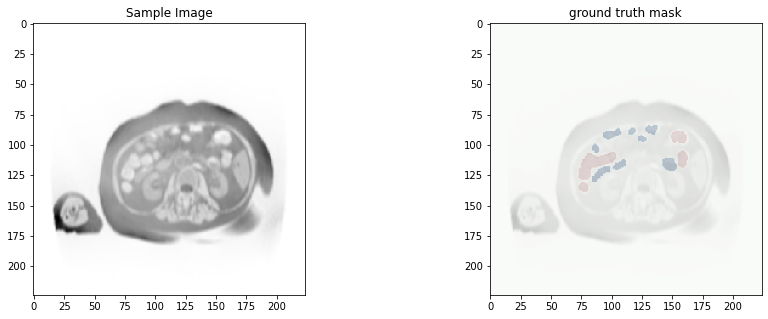

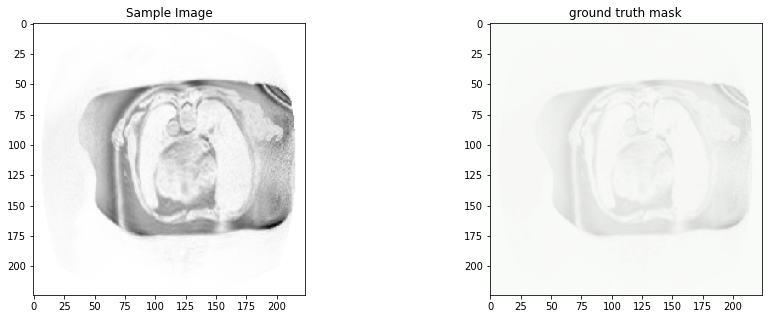

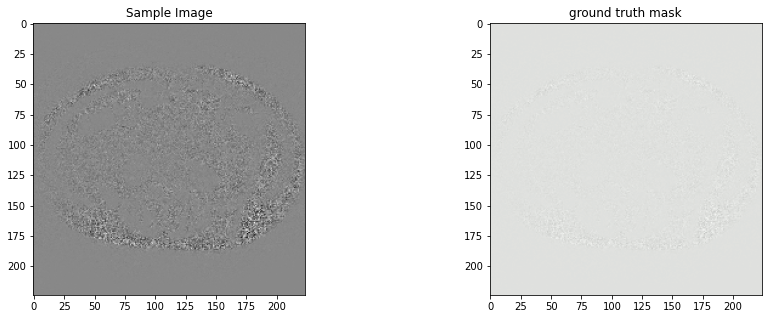

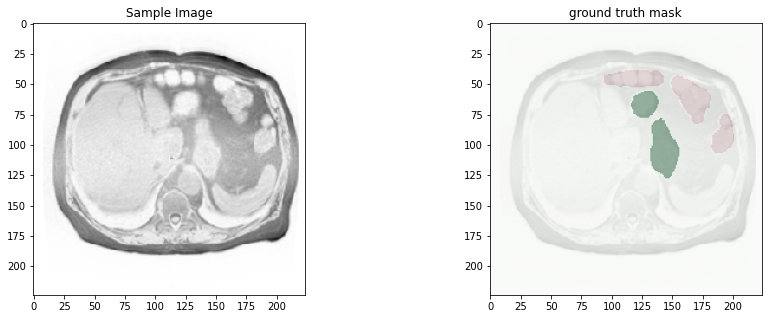

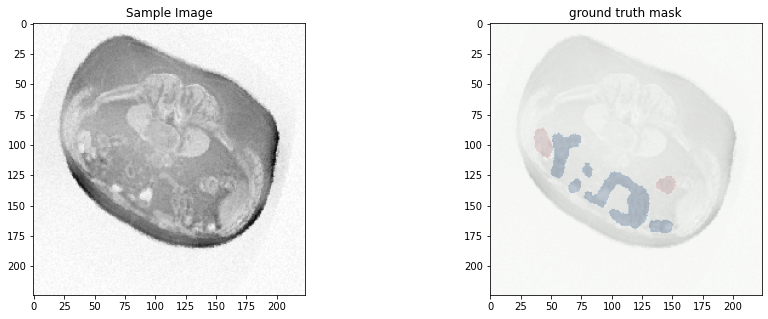

In [25]:
data = ImageDataset(loaded_images, data_df, transform=data_transforms, tp=0.8)

for i in range(10):
    i = random.randint(0, len(data)-1)
    image, gt_mask = data[i]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    alpha = 0.4

    image = image_resize(image, size=(gt_mask.shape[1:]))

    axs[0].imshow(image.squeeze(), cmap='gray')
    axs[0].set_title('Sample Image')

    axs[1].imshow(image.squeeze(), cmap='gray')
    axs[1].imshow(gt_mask[0], cmap='Reds', alpha=alpha)
    axs[1].imshow(gt_mask[1], cmap='Blues', alpha=alpha)
    axs[1].imshow(gt_mask[2], cmap='Greens', alpha=alpha)
    axs[1].set_title('ground truth mask')

# The Nueral Network

The neural network is a custom network made as a result of experimentation in this notebook. The network architecture is an encoder decoder architecture. The encoder is responsible for representing the input image in 5 latent feature maps, the last latent representation is upsampled across each block of the decoder and the remaining 4 are used to establish residual connection between encoder and decoder.

### Schematic Diagram of the Neural Network Architecture

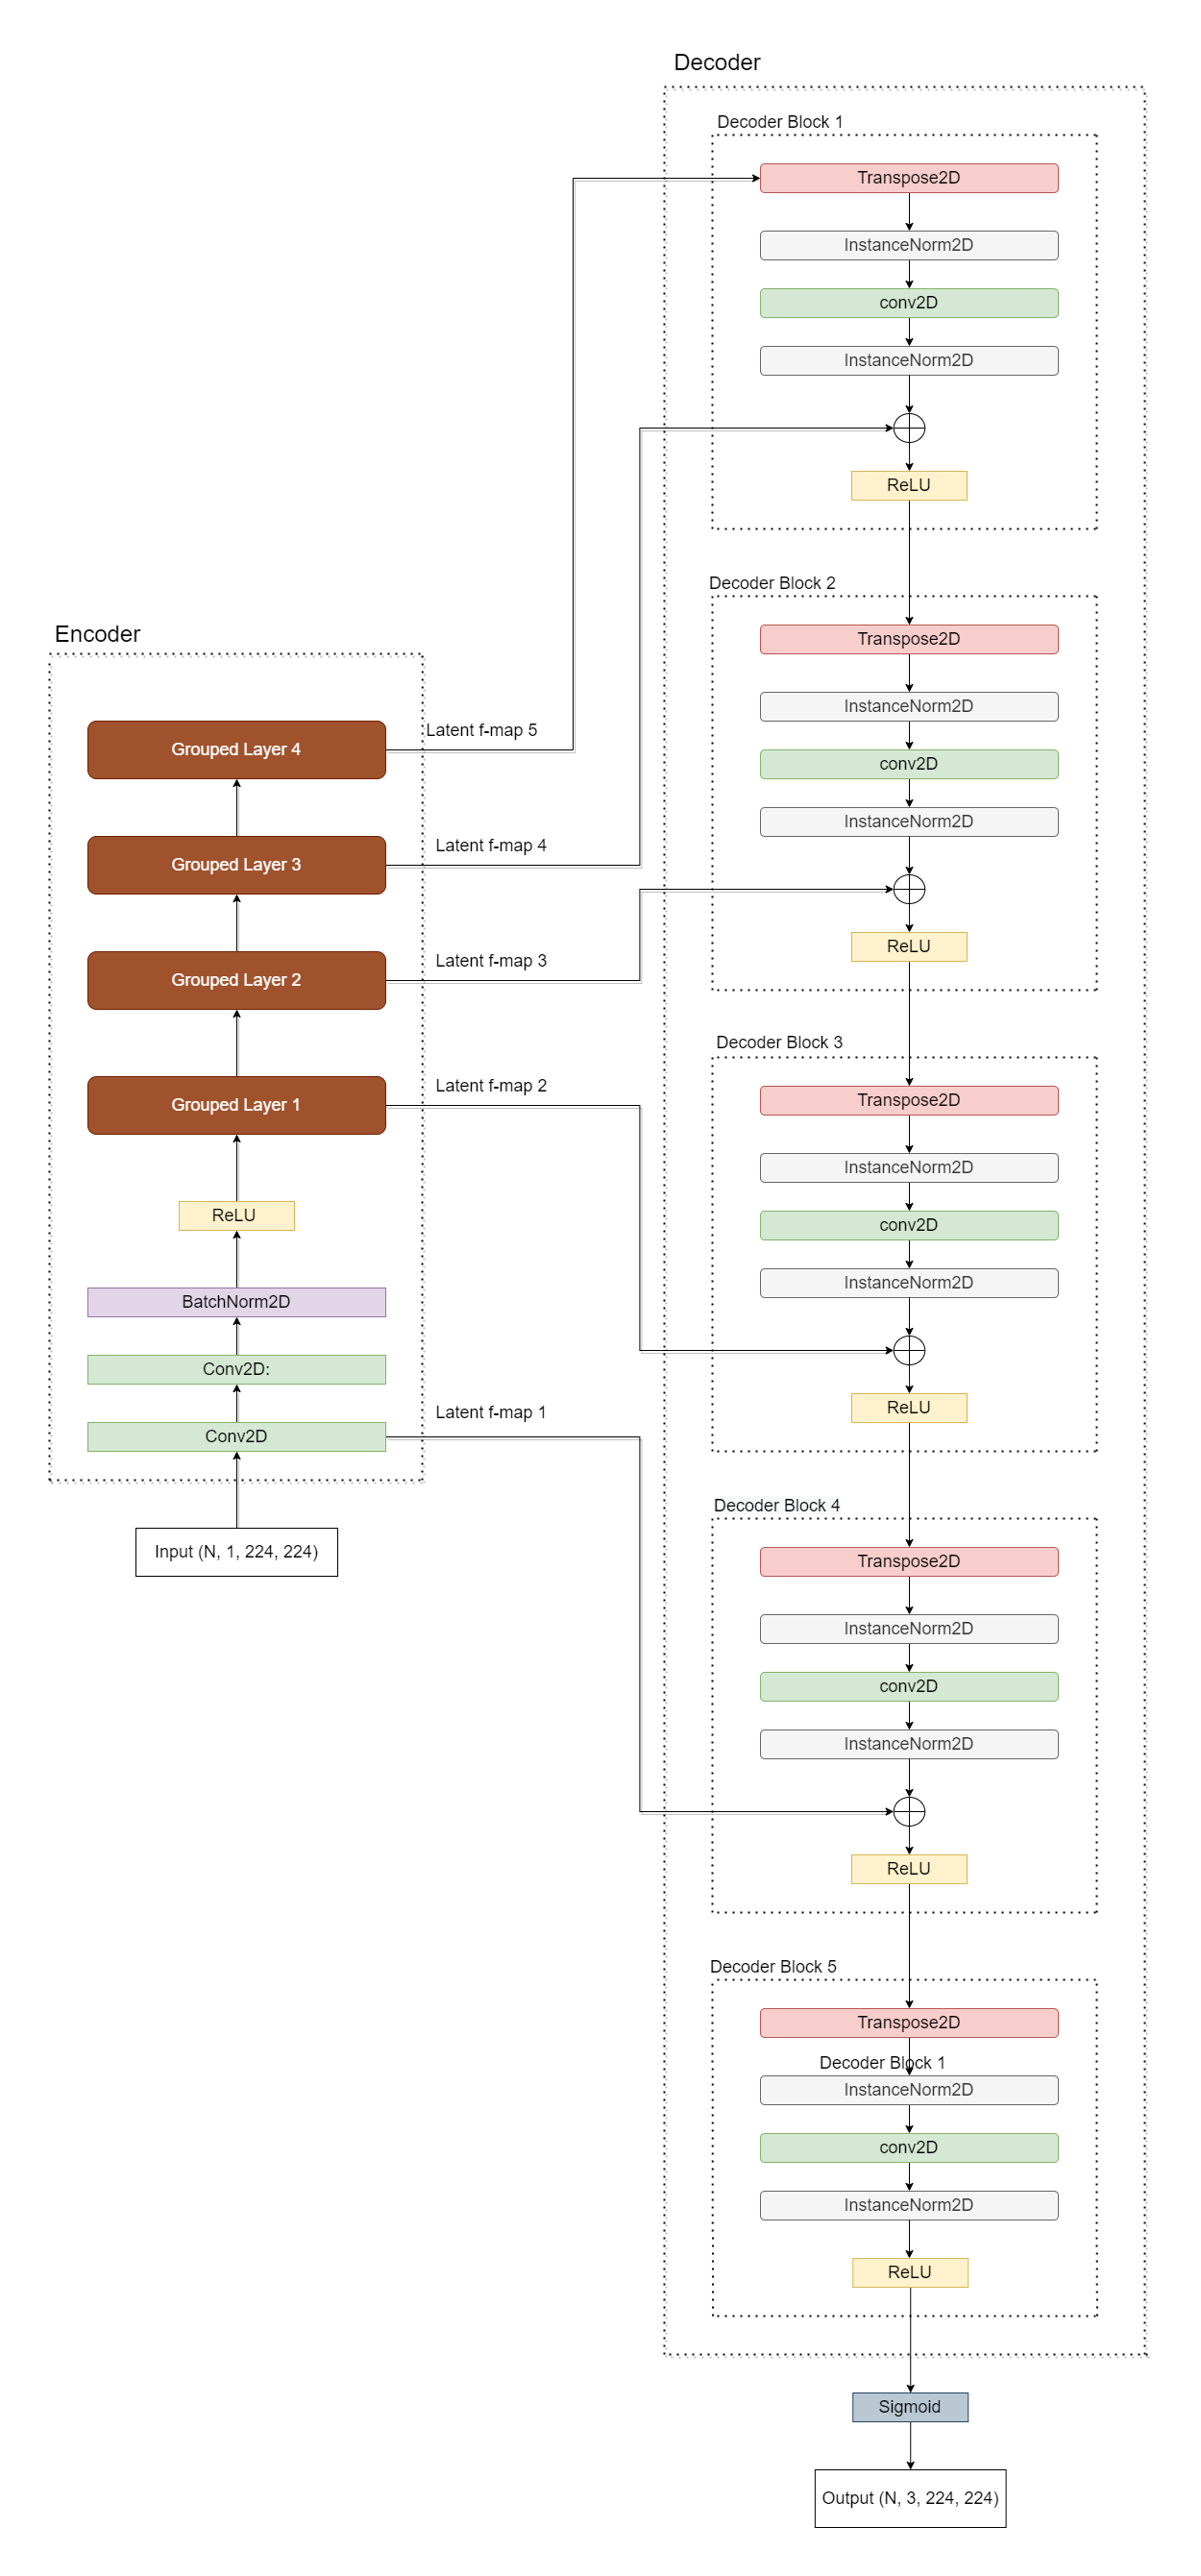

The **encoder** is a ResNet-34 architecture with an extra convolutional layer, without any pooling and dense layers. In the architectural diagram above, a grouped layer is a layer with multiple residual blocks. In the ResNet-34, the first, second, third and fourth grouped layer comprises 3, 4, 6 and 3 residual blocks (`BasicBlock`) respectively.

The **decoder** comprises 5 decoder blocks as shown in the schematic diagram above. The dimensions of the feature maps and decoder block outputs are as shown below:

### Encoder Latent Feature Map Dimensions
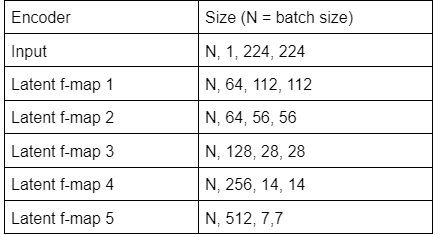


### Decoder Block Output Dimensions
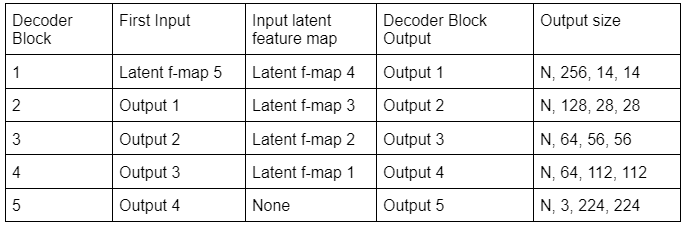


The cell below sets seeding parameters for the RNG responsible for initialising model parameters,this is done for the sake of reproducability.

In [26]:
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## The Encoder Network Implementation

In [27]:
class SpatialEncoder(ResNet):
    def __init__(
        self, input_channels, block=BasicBlock, block_layers=[3, 4, 6, 3]):
      
        self.block = block
        self.block_layers = block_layers
        
        super(SpatialEncoder, self).__init__(self.block, self.block_layers)
        
        self.input_channels = input_channels
        
        self.conv1 = nn.Conv2d(
            self.input_channels, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False)
        
        self.conv2 = nn.Conv2d(
            64, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3),
            bias=False)

        #delete unwanted layers
        del self.maxpool, self.fc, self.avgpool
        
        
    def forward(self, x):
        fmap1 = self.conv1(x)
        x = self.conv2(fmap1)
        x = self.bn1(x)
        x = self.relu(x)
        fmap2 = self.layer1(x)
        fmap3 = self.layer2(fmap2)
        fmap4 = self.layer3(fmap3)
        fmap5 = self.layer4(fmap4)
        
        return fmap1, fmap2, fmap3, fmap4, fmap5

## The Decoder Block Implementation

In [28]:
class DecoderBlock(nn.Module):
    def __init__(self, input_channels, output_channels, upsample_scale=2, activation=nn.ReLU):
        super(DecoderBlock, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.upsample_scale = upsample_scale

        self.transpose = nn.ConvTranspose2d(
            self.input_channels, self.input_channels, 
            kernel_size=self.upsample_scale, stride=self.upsample_scale)
        
        self.instance_norm1 = nn.InstanceNorm2d(self.transpose.in_channels)

        self.conv = nn.Conv2d(
            self.transpose.out_channels, self.output_channels, kernel_size=3, stride=1, padding=1)
        
        self.instance_norm2 = nn.InstanceNorm2d(self.conv.out_channels)
        
        self.activation = activation()

    
    def forward(self, fmap, prev_fmap=None):
        output = self.transpose(fmap)
        output = self.instance_norm1(output)
        output = self.conv(output)
        output = self.instance_norm2(output)

        if torch.is_tensor(prev_fmap):
            assert (prev_fmap.shape == output.shape), 'feature maps must be of same shape'
            output += prev_fmap
            
        output = self.activation(output)
        return output

## The Decoder Network Implementation

In [29]:
class Decoder(nn.Module):
    def __init__(
        self, last_fmap_channels, output_channels, n_classes, first_fmap_channels=64):
        super(Decoder, self).__init__()
        
        self.last_fmap_channels = last_fmap_channels
        self.first_fmap_channels = first_fmap_channels
        self.output_channels = output_channels
        self.n_classes = n_classes

        self.residual_layers = self.make_layers()

        self.final_layer = DecoderBlock(
            self.residual_layers[-1].input_channels, self.output_channels*self.n_classes,
            activation=nn.Sigmoid)
        self.final_layer.instance_norm2 = nn.Identity()


    def forward(self, *fmaps):
        #fmaps(reversed): fmap5, fmap4, fmap3, fmap2, fmap1
        fmaps = [fmap for fmap in reversed(fmaps)]
        ouptut = None
        for idx, m in enumerate(self.residual_layers):
            if idx == 0:
                output = m(fmaps[idx], fmaps[idx+1])
                continue
            output = m(output, fmaps[idx+1])
        
        output = self.final_layer(output)
        return output

      
    def make_layers(self, n=4):
        layers = []
        for i in range(n):
            if i == 0: in_ch = self.last_fmap_channels
            else: in_ch = layers[i-1].output_channels

            out_ch = in_ch // 2 if i != (n-1) else self.first_fmap_channels
            layer = DecoderBlock(in_ch, out_ch)
            layers.append(layer)

        layers = nn.ModuleList(layers)
        return layers

## The Segmentation Network

In [30]:
class SegmentNet(nn.Module):
    def __init__(self, encoder:SpatialEncoder, decoder:Decoder, device='cpu'):
        
        super(SegmentNet, self).__init__()
        
        self.device = device
        self.encoder = encoder
        self.decoder = decoder
        
        self.to(self.device)
    
    def forward(self, x, output_size=None):
        enc_fmaps = self.encoder(x)
        segmentation_mask = self.decoder(*enc_fmaps)

        if output_size and tuple(segmentation_mask.shape[2:]) != tuple(output_size):
            segmentation_mask = image_resize(segmentation_mask, size=output_size)
        
        return segmentation_mask

# Model Traning Pipeline Class

This class is responsible for the training and testing of the model. The class takes as argument the neural network model, the loss function, the optimizer and other parameters pertaining to weight initialisation, these arguments are then used to form a training and testing pipeline. The class has three methods; the training and testing methods, and the method that saves the model and optimizer parameters.

In [31]:
class FitterPipeline:
    def __init__(self, model, lossfunc, optimizer, device='cpu', 
                 weight_init=True, custom_weight_initializer=None):
        
        self.device = device
        self.model = model.to(self.device)
        self.lossfunc = lossfunc
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.custom_weight_initializer = custom_weight_initializer
        
        if self.weight_init:
            if self.custom_weight_initializer:
                self.model.apply(self.custom_weight_initializer)
            else:
                self.model.apply(self.xavier_init_weights)
        
    
    def xavier_init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight)
            if torch.is_tensor(m.bias):
                m.bias.data.fill_(0.01)
    
    
    def save_model(self, dirname='./model_params', 
                   filename='tumor_segmentation_params.pth.tar'):
        if not os.path.isdir(dirname):os.mkdir(dirname)
        state_dicts = {
            'segmentation_net_params':self.model.state_dict(),
            'optimizer_params':self.optimizer.state_dict(),
        }
        return torch.save(state_dicts, os.path.join(dirname, filename))
        

    def train(self, dataloader, epochs=1, verbose=False):
        self.model.train()
        
        losses, hds, dice_coeffs = [], [], []
        for epoch in range(epochs):
            loss, hd, dice_coeff = 0, 0, 0
            for idx, (image, gt_mask) in tqdm.tqdm(enumerate(dataloader)):

                self.model.zero_grad()
                image, gt_mask = image.to(self.device), gt_mask.to(self.device)
                
                pred_mask = self.model(image, output_size=tuple(gt_mask.shape[2:]))
                
                #batch loss
                batch_loss = self.lossfunc(pred_mask, gt_mask)

                #backward propagation
                batch_loss.backward()
                self.optimizer.step()
                
                #metric values
                batch_hd, batch_dice_coeff, _ = self.lossfunc.metric_values(pred_mask, gt_mask)

                loss += batch_loss.item()
                dice_coeff += batch_dice_coeff
                hd += batch_hd
            
            loss = loss / (idx + 1)
            hd = hd / (idx + 1)
            dice_coeff = dice_coeff / (idx + 1)
            
            if verbose:
                print(f'epoch: {epoch} \nTraining Loss: {loss} \nTrain Dice Coeff: {dice_coeff} \nTrain Hausdorff Distance: {hd}')
            losses.append(loss)
            hds.append(hd)
            dice_coeffs.append(dice_coeff)
        return losses, hds, dice_coeffs
    
    
    def test(self, dataloader, verbose=False):
        self.model.eval()
        
        loss, hd, dice_coeff = 0, 0, 0
        with torch.no_grad():
            for idx, (image, gt_mask) in tqdm.tqdm(enumerate(dataloader)):

                image, gt_mask = image.to(self.device), gt_mask.to(self.device)

                pred_mask = self.model(image, output_size=tuple(gt_mask.shape[2:]))

                #batch loss
                batch_loss = self.lossfunc(pred_mask, gt_mask)
                                
                #metric values
                batch_hd, batch_dice_coeff, _ = self.lossfunc.metric_values(pred_mask, gt_mask)

                loss += batch_loss.item()
                dice_coeff += batch_dice_coeff
                hd += batch_hd
            
        loss = loss / (idx + 1)
        hd = hd / (idx + 1)
        dice_coeff = dice_coeff / (idx + 1)

        if verbose:
            print(f'\n Testing Loss: {loss}  \nTest Dice Coeff: {dice_coeff} \nTest Hausdorff Distance: {hd}')
        return loss, hd, dice_coeff

# Data Preparation

The function below is created to trim down row samples in the dataframe where no RLE is present in all three classes. This is done to reduce the number of training and testing samples, to save computation time during model training and testing

In [32]:
def trim_empty_tag(df, p):
    rand_n = np.random.rand()
    df['to_delete'] = False
    if df.is_empty == True:
        if rand_n < p:
            df['to_delete'] = True
    return df

def trim_empty(df, images, p=0.3):
    assert p <= 1, 'p should be within range of 0 and 1'
    trim = lambda df: trim_empty_tag(df, p)
    df = df.apply(trim, axis=1)

    trim_mask = df['to_delete'].values
    images = [i for (i, m) in zip(images, trim_mask) if m != True]
    df = df[df['to_delete'] != True]
    df.index = [i for i in range(len(df))]
    return df, images

The dataset is split into 3, 90% is used for training, 5% is used for robustness testing, and the remaining 5% for regular testing. Robustness testing simply entails that the testing data is augmented and used to test model robustness. 

The `trim_empty` function is applied to training data and the augmented testing data, this function is utilised to trim out 85% of samples with no RLE / mask across any of the 3 classes.

The dataset class objects corresponding to training and robust testing have their `tp` values set to 0.85 and 0.5 respectively, the other testing set has a `tp` value set to 0, so as to test the model on non-tampered data.

The corresponding dataloaders for the 3 data splits are also instantiated with a batch size set to 32.

In [33]:
train_size = 0.9
test_size = 0.05

train_length = int(len(loaded_images) * train_size)
test_length = int(len(loaded_images) * test_size)

train_images, test_images, eval_images = (
    loaded_images[:train_length],
    loaded_images[train_length:train_length+test_length],
    loaded_images[train_length+test_length:])

train_data_df, test_data_df, eval_data_df = (
    data_df.iloc[:train_length, :], 
    data_df.iloc[train_length:train_length+test_length, :],
    data_df.iloc[train_length+test_length:, :])

test_data_df.index = [i for i in range(len(test_data_df))]
eval_data_df.index = [i for i in range(len(eval_data_df))]

#reduce the number of empty samples for training and testing data

train_data_df, train_images = trim_empty(train_data_df, train_images, p=0.85)
test_data_df, test_images = trim_empty(test_data_df, test_images, p=0.85)
eval_data_df, eval_images = trim_empty(eval_data_df, eval_images)


batch_size = 32

train_data = ImageDataset(train_images, train_data_df, transform=data_transforms, tp=0.85)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)

test_data = ImageDataset(test_images, test_data_df, transform=data_transforms, tp=0.50)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=2)

eval_data = ImageDataset(eval_images, eval_data_df, transform=None)
eval_dataloader = DataLoader(eval_data, shuffle=True, batch_size=batch_size, num_workers=2)

Next, bar plots are made for the three data splits to visualise the frequency of image samples without mask segments, compared to that of image samples with atleast one mask segment

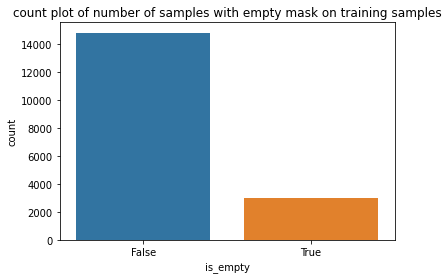

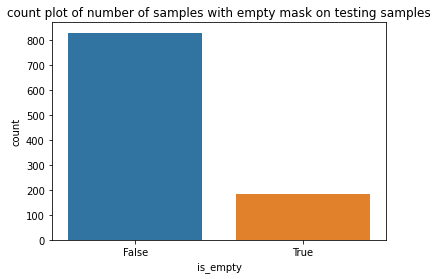

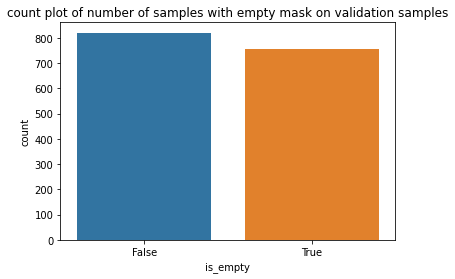

In [34]:
sns.countplot(x ='is_empty', data = train_data_df)
plt.title('count plot of number of samples with empty mask on training samples')
plt.show()

sns.countplot(x ='is_empty', data = test_data_df)
plt.title('count plot of number of samples with empty mask on testing samples')
plt.show()

sns.countplot(x ='is_empty', data = eval_data_df)
plt.title('count plot of number of samples with empty mask on validation samples')
plt.show()

In [35]:
del data_df, loaded_images
gc.collect()

8083

# The Loss Function

### Loss functions
The loss function utilised in this implementation is a combination of three kinds of losses, namely: **Probability distribution loss**, **Region based loss** and **Boundary based loss**

The loss is given as: $L = (1+L_{bce})[1 - (w_1 (1-L_{hd}) + w_2 (1 - L_{dc}))]$
Where w_1 and w_2 are weights values attached to the boundary and region based losses respectively.
Here we add 1 to the probability distribution loss to prevent vanishing gradients when it finally gets minimised.

The probability distribution loss is the Binary Cross Entropy loss. This loss aims to reduce the probability distribution between ground truth and prediction.
The loss is given as: $L_{bce} = ylog(x) + (1 - y)log(1 - x)$

The region based loss used is the dice loss. This loss aims to improve the jaccard index (intersection over union) between ground truth and prediction.
The loss is given as: $L_{dc} = 1 - [ \frac {2(Y \cap X)} {Y + X}]$

The boundary based loss used is the hausdorff distance metric: minimising this metric ensures that the magnitudinal distance between surfaces of ground tuth and prediction is tending towards 0 than to 1.
The loss is given as: $L_{hd} = max( max_x (min_y (||x - y||)), max_y (min_x (||y - x||)) ]$, where x ∈ X and y ∈ Y

In [36]:
class SegementationMetric(nn.Module):
    def __init__(self, w1=0.5, w2=0.5):
        """
        w1 corresponds to weightage of hausdorff distance
        w2 corresponds to weightage of dice coefficent score
        """

        assert w1 + w2 == 1, 'sum of all weights must be equal to 1'
        super(SegementationMetric, self).__init__()

        self.w1 = w1
        self.w2 = w2
        self.bce_loss = nn.BCELoss()

    
    def hausdorff_distance(self, pred, target):
        #pred shape: (N, C, H, W)
        #target shape: (N, C, H, W)
        pred = pred.detach().cpu().round()
        target = target.cpu()
        
        max_dist = max(target.shape[2:])

        warnings.filterwarnings("ignore")

        #compute the hausdorff distance for each batch
        batch_distances = compute_hausdorff_distance(pred, target, distance_metric='euclidean', include_background=True)

        batch_distances[batch_distances == torch.inf] = max_dist
        batch_distances[batch_distances != batch_distances] = 0

        #get max distance for each batch and compute mean
        batch_distances = batch_distances.max(dim=1)
        dist = batch_distances[0].mean()
        dist = dist / max_dist
        return dist


    def dice_coeff(self, prediction, ground_truth, epsilon=1e-5):
        #input shape: N, C, H, W
        prediction = prediction.cpu().round()
        ground_truth = ground_truth.cpu()
        intersection = torch.sum(torch.abs(ground_truth * prediction), dim=(2, 3))
        denominator = ground_truth.sum(dim=(2, 3)) + prediction.sum(dim=(2, 3))
        dice_coeff = ((2 * intersection + epsilon) / (denominator + epsilon)).mean(dim=(0, 1))
        return dice_coeff.item()

      
    def metric_values(self, prediction, ground_truth):
        #input shape: N, C, H, W
        hausdorff_distance = self.hausdorff_distance(prediction, ground_truth)
        dice_coeff = self.dice_coeff(prediction, ground_truth)
        bce_loss = self.bce_loss(prediction, ground_truth)

        return hausdorff_distance, dice_coeff, bce_loss

    
    def forward(self, prediction, ground_truth):
        #input shape: N, C, H, W
        hausdorff_distance, dice_coeff, bce_loss = self.metric_values(prediction, ground_truth)
        hausdorff_distance = torch.tensor(hausdorff_distance)

        acc_score = (self.w1 * (1 - hausdorff_distance)) + (self.w2 * dice_coeff)
        loss = (1 + bce_loss) * (1 - acc_score).requires_grad_(True)
        return loss
    

# Model Training and Testing

## Preparations

The encoder and decoder are instantiated and are in-turn, used to instantiate the model via the `SegmentNet` class

The optimizer used for this implementation is the ADAM (Adaptive Moment Estimation) optimizer with initial learning rate of 1e-3.

The loss function is instantiated with $w_1$ and $w_2$ both set to 0.5.

In [37]:
input_channels = 1 
first_fmap_channels = 64
last_fmap_channels = 512 #2048
output_channels = 1 
n_classes=3

encoder = SpatialEncoder(input_channels)
decoder = Decoder(last_fmap_channels, output_channels, n_classes, first_fmap_channels)

model = SegmentNet(encoder, decoder)

learning_rate = 1e-3
weight_decay = 0.0
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lossfunc = SegementationMetric(w1=0.5, w2=0.5)

In [38]:
model

SegmentNet(
  (encoder): SpatialEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64,

In [39]:
num_params = sum([i.numel() for i in model.parameters()])
print(f'Number of model trainable parameters: {num_params}')

Number of model trainable parameters: 24476547


Next the training pipeline class is instantiated below.

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipeline = FitterPipeline(model, lossfunc, optimizer, device, weight_init=False)

subsequently after model and optimizer intantiation in the previous cell, trained parameters from the [earlier version](https://www.kaggle.com/code/henrychibueze/tumor-detection-in-mri-scans?scriptVersionId=105696070) of this notebook is used to initialise the model and optimizer parameters.

The trained parameters from the earlier version were able to attain an accuracies of 88.7% and 92% on the augmented and non-augmented test set.

In [41]:
path = '../input/tumor-detection-in-mri-scans/model_params/tumor_segmentation_params.pth.tar'

params = torch.load(path, map_location=device)

model_params = params['segmentation_net_params']
optimizer_params = params['optimizer_params']

pipeline.model.load_state_dict(model_params)
pipeline.optimizer.load_state_dict(optimizer_params)

In the [earlier version](https://www.kaggle.com/code/henrychibueze/tumor-detection-in-mri-scans?scriptVersionId=105696070) of this notebook, the cosine annealing warm restart learning rate sheduler was utilised for learning rate decay. In that version, the `T_0` argument was set to 20, with `T_mult` set to 2, and the model was trained for 60 epochs, thus there was a learning rate restart after the first 20 epochs, and from then onwards up till the 60th epoch, the learning rate decayed gradually from $10 e^{-3}$ to $10 e^{-6}$ with no restart. In this notebook version however, there will be no learning rate restart, as`T_0` would be set to the number of training epochs (60), hence the learning rate would decay gradually from maximum to minimum in the span of 60 epochs.

In [42]:
EPOCHS = 60
min_lr = 1e-6

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    pipeline.optimizer, T_0=EPOCHS, T_mult=2, eta_min=min_lr, verbose =True
)

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


## Training and Testing Cycle

In [43]:
print(f'Model is training on {torch.cuda.get_device_name()} \n\n')

training_losses, training_hds, training_dice_coeffs = [], [], []
testing_losses, testing_hds, testing_dice_coeffs = [], [], []

w1, w2 = 0.5, 0.5

best_loss = np.inf
for i in range(EPOCHS):
    print(f'\n\nepoch: {i}')
    train_loss, training_hd, train_dice_coeff = pipeline.train(train_dataloader)
    training_losses.append(train_loss[0])
    training_hds.append(training_hd[0])
    training_dice_coeffs.append(train_dice_coeff[0])
    print(
        f'\ntraining loss: {train_loss[0]}',
        f'\ntraining hausdorff dist: {training_hd[0]}',
        f'\ntraining dice coeff: {train_dice_coeff[0]}', 
        f'\ntrain score: {(w1 * (1 - training_hd[0])) + (w2 * train_dice_coeff[0])}')
    
    test_loss, testing_hd, test_dice_coeff = pipeline.test(test_dataloader)
    testing_losses.append(test_loss)
    testing_hds.append(testing_hd)
    testing_dice_coeffs.append(test_dice_coeff)
    print(f'testing loss: {test_loss}', 
          f'\ntesting hausdorff dist: {testing_hd}', 
            f'\ntesting dice coeff: {test_dice_coeff}',
          f'\ntest score: {(w1 * (1 - testing_hd)) + (w2 * test_dice_coeff)}')

    if test_loss < best_loss:
        best_loss = test_loss
        pipeline.save_model()
        print(f'model saved at epoch {i}')
    
    lr_scheduler.step()

Model is training on Tesla P100-PCIE-16GB 




epoch: 0


556it [10:17,  1.11s/it]


training loss: 0.23721972374056766 
training hausdorff dist: 0.2594155354599674 
training dice coeff: 0.7919687647238481 
train score: 0.7662766146319404



32it [00:19,  1.65it/s]


testing loss: 0.1815983588991755 
testing hausdorff dist: 0.19412074050324613 
testing dice coeff: 0.8347516264766455 
test score: 0.8203154429866997
model saved at epoch 0
Epoch 00001: adjusting learning rate of group 0 to 9.9932e-04.


epoch: 1


556it [09:55,  1.07s/it]


training loss: 0.17123005106675257 
training hausdorff dist: 0.1794601794139249 
training dice coeff: 0.8406178201917264 
train score: 0.8305788203889007



32it [00:19,  1.61it/s]


testing loss: 0.156268321581252 
testing hausdorff dist: 0.17109967490690087 
testing dice coeff: 0.861519755795598 
test score: 0.8452100404443486
model saved at epoch 1
Epoch 00002: adjusting learning rate of group 0 to 9.9726e-04.


epoch: 2


556it [09:43,  1.05s/it]


training loss: 0.1682134830702439 
training hausdorff dist: 0.17654587908691763 
training dice coeff: 0.8435578270138596 
train score: 0.8335059739634709



32it [00:21,  1.52it/s]


testing loss: 0.18589269698128916 
testing hausdorff dist: 0.1983576688926881 
testing dice coeff: 0.830349812284112 
test score: 0.815996071695712
Epoch 00003: adjusting learning rate of group 0 to 9.9385e-04.


epoch: 3


556it [10:06,  1.09s/it]


training loss: 0.16051787511724072 
training hausdorff dist: 0.16698036142492664 
training dice coeff: 0.8491527672937448 
train score: 0.841086202934409



32it [00:19,  1.65it/s]


testing loss: 0.2624364074126098 
testing hausdorff dist: 0.2856866185171811 
testing dice coeff: 0.7688338309526443 
test score: 0.7415736062177316
Epoch 00004: adjusting learning rate of group 0 to 9.8908e-04.


epoch: 4


556it [09:56,  1.07s/it]


training loss: 0.17792655117748385 
training hausdorff dist: 0.18884368614898187 
training dice coeff: 0.8367620082639105 
train score: 0.8239591610574644



32it [00:19,  1.66it/s]


testing loss: 0.15947249568157795 
testing hausdorff dist: 0.17168866868181074 
testing dice coeff: 0.8556584361940622 
test score: 0.8419848837561257
Epoch 00005: adjusting learning rate of group 0 to 9.8298e-04.


epoch: 5


556it [09:56,  1.07s/it]


training loss: 0.16018573940929343 
training hausdorff dist: 0.16706721786121276 
training dice coeff: 0.849838466845828 
train score: 0.8413856244923077



32it [00:19,  1.66it/s]


testing loss: 0.1707077750437297 
testing hausdorff dist: 0.18329864769737322 
testing dice coeff: 0.8450713492929935 
test score: 0.8308863507978101
Epoch 00006: adjusting learning rate of group 0 to 9.7555e-04.


epoch: 6


556it [09:41,  1.05s/it]


training loss: 0.1619729505479416 
training hausdorff dist: 0.16981431635382369 
training dice coeff: 0.8490419491803903 
train score: 0.8396138164132834



32it [00:18,  1.71it/s]


testing loss: 0.15652507548853317 
testing hausdorff dist: 0.1684731943195336 
testing dice coeff: 0.8581451699137688 
test score: 0.8448359877971177
Epoch 00007: adjusting learning rate of group 0 to 9.6682e-04.


epoch: 7


556it [09:52,  1.07s/it]


training loss: 0.15200374470206363 
training hausdorff dist: 0.15749379484828555 
training dice coeff: 0.8563135764796099 
train score: 0.8494098908156622



32it [00:19,  1.62it/s]


testing loss: 0.14765115889732172 
testing hausdorff dist: 0.15650571217464274 
testing dice coeff: 0.8637199159711599 
test score: 0.8536071018982586
model saved at epoch 7
Epoch 00008: adjusting learning rate of group 0 to 9.5682e-04.


epoch: 8


556it [10:05,  1.09s/it]



training loss: 0.15150577312428465 
training hausdorff dist: 0.1566521541053429 
training dice coeff: 0.8564699945046748 
train score: 0.8499089201996659


32it [00:20,  1.59it/s]

testing loss: 0.1621023461104673 
testing hausdorff dist: 0.1725244190414286 
testing dice coeff: 0.8514643087983131 
test score: 0.8394699448784423
Epoch 00009: adjusting learning rate of group 0 to 9.4556e-04.


epoch: 9



556it [10:00,  1.08s/it]



training loss: 0.16361157717699024 
training hausdorff dist: 0.1725975249581846 
training dice coeff: 0.848553403139972 
train score: 0.8379779390908937


32it [00:19,  1.65it/s]


testing loss: 0.213342320044703 
testing hausdorff dist: 0.2240184794022786 
testing dice coeff: 0.802453801035881 
test score: 0.7892176608168012
Epoch 00010: adjusting learning rate of group 0 to 9.3308e-04.


epoch: 10


556it [10:00,  1.08s/it]


training loss: 0.1611470051148167 
training hausdorff dist: 0.16861269437719012 
training dice coeff: 0.8494533779595396 
train score: 0.8404203417911746



32it [00:18,  1.72it/s]


testing loss: 0.16396470353273115 
testing hausdorff dist: 0.17717642410678788 
testing dice coeff: 0.8521754536777735 
test score: 0.8374995147854928
Epoch 00011: adjusting learning rate of group 0 to 9.1942e-04.


epoch: 11


556it [10:15,  1.11s/it]



training loss: 0.15055280304157234 
training hausdorff dist: 0.15736003391263262 
training dice coeff: 0.858991459440842 
train score: 0.8508157127641047


32it [00:19,  1.64it/s]


testing loss: 0.15616401272225622 
testing hausdorff dist: 0.15984487242100487 
testing dice coeff: 0.8502924032509327 
test score: 0.8452237654149639
Epoch 00012: adjusting learning rate of group 0 to 9.0460e-04.


epoch: 12


556it [10:16,  1.11s/it]


training loss: 0.14681405533515693 
training hausdorff dist: 0.15204668904648888 
training dice coeff: 0.8610658335814373 
train score: 0.8545095722674743



32it [00:20,  1.56it/s]


testing loss: 0.1431980367850119 
testing hausdorff dist: 0.14882387211458598 
testing dice coeff: 0.8648868035525084 
test score: 0.8580314657189612
model saved at epoch 12
Epoch 00013: adjusting learning rate of group 0 to 8.8868e-04.


epoch: 13


556it [10:04,  1.09s/it]



training loss: 0.14561221173084601 
training hausdorff dist: 0.15018719727948016 
training dice coeff: 0.8615557224416047 
train score: 0.8556842625810623


32it [00:20,  1.56it/s]

testing loss: 0.15191982403929788 
testing hausdorff dist: 0.15826398158928323 
testing dice coeff: 0.8571301605552435 
test score: 0.8494330894829801
Epoch 00014: adjusting learning rate of group 0 to 8.7170e-04.


epoch: 14



556it [10:19,  1.11s/it]


training loss: 0.14404225737751422 
training hausdorff dist: 0.14822926409910928 
training dice coeff: 0.8627011326791572 
train score: 0.857235934290024



32it [00:20,  1.55it/s]


testing loss: 0.13882325138988708 
testing hausdorff dist: 0.14534524594755294 
testing dice coeff: 0.8699982427060604 
test score: 0.8623264983792538
model saved at epoch 14
Epoch 00015: adjusting learning rate of group 0 to 8.5370e-04.


epoch: 15


556it [10:23,  1.12s/it]


training loss: 0.14663615615941467 
training hausdorff dist: 0.1523622439802268 
training dice coeff: 0.8616967092958285 
train score: 0.8546672326578009



32it [00:19,  1.64it/s]


testing loss: 0.14053694477850648 
testing hausdorff dist: 0.14854969618732755 
testing dice coeff: 0.8697246517986059 
test score: 0.8605874778056392
Epoch 00016: adjusting learning rate of group 0 to 8.3473e-04.


epoch: 16


556it [10:21,  1.12s/it]


training loss: 0.14186703354266925 
training hausdorff dist: 0.14740675702514477 
training dice coeff: 0.8661417113148051 
train score: 0.8593674771448302



32it [00:20,  1.55it/s]


testing loss: 0.12777511960292087 
testing hausdorff dist: 0.13193546973240905 
testing dice coeff: 0.8784052282571793 
test score: 0.8732348792623851
model saved at epoch 16
Epoch 00017: adjusting learning rate of group 0 to 8.1485e-04.


epoch: 17


556it [09:53,  1.07s/it]


training loss: 0.13858183655470696 
training hausdorff dist: 0.14201858056293148 
training dice coeff: 0.867269306624536 
train score: 0.8626253630308023



32it [00:19,  1.62it/s]

testing loss: 0.13504591302600766 
testing hausdorff dist: 0.1447047752756653 
testing dice coeff: 0.8767803106456995 
test score: 0.8660377676850171
Epoch 00018: adjusting learning rate of group 0 to 7.9410e-04.


epoch: 18



556it [10:14,  1.10s/it]


training loss: 0.13765071543866428 
training hausdorff dist: 0.14194350985446588 
training dice coeff: 0.8690020736816119 
train score: 0.8635292819135729



32it [00:19,  1.63it/s]


testing loss: 0.12559944260119238 
testing hausdorff dist: 0.1271401372914118 
testing dice coeff: 0.8778164684772491 
test score: 0.8753381655929187
model saved at epoch 18
Epoch 00019: adjusting learning rate of group 0 to 7.7255e-04.


epoch: 19


556it [10:15,  1.11s/it]


training loss: 0.13928519219905588 
training hausdorff dist: 0.14446506627255745 
training dice coeff: 0.8682692803496079 
train score: 0.8619021070385252



32it [00:19,  1.62it/s]

testing loss: 0.1469169273885744 
testing hausdorff dist: 0.15651220886877196 
testing dice coeff: 0.8650922775268555 
test score: 0.8542900343290418
Epoch 00020: adjusting learning rate of group 0 to 7.5025e-04.


epoch: 20



556it [10:03,  1.09s/it]


training loss: 0.1367418498418788 
training hausdorff dist: 0.14074197096055213 
training dice coeff: 0.8695695455983389 
train score: 0.8644137873188933



32it [00:20,  1.58it/s]

testing loss: 0.1270846310697126 
testing hausdorff dist: 0.1306357224469027 
testing dice coeff: 0.8784087207168341 
test score: 0.8738864991349657
Epoch 00021: adjusting learning rate of group 0 to 7.2727e-04.


epoch: 21



556it [09:55,  1.07s/it]


training loss: 0.13106050810386757 
training hausdorff dist: 0.13367239204777157 
training dice coeff: 0.8736993414249351 
train score: 0.8700134746885817



32it [00:19,  1.61it/s]


testing loss: 0.12796038765822232 
testing hausdorff dist: 0.13512719764842282 
testing dice coeff: 0.8810883406549692 
test score: 0.8729805715032732
Epoch 00022: adjusting learning rate of group 0 to 7.0366e-04.


epoch: 22


556it [10:15,  1.11s/it]


training loss: 0.1288302333291201 
training hausdorff dist: 0.1317639350352882 
training dice coeff: 0.8761984973931484 
train score: 0.8722172811789302



32it [00:19,  1.66it/s]

testing loss: 0.12756043325010913 
testing hausdorff dist: 0.13291280806753872 
testing dice coeff: 0.8797362539917231 
test score: 0.8734117229620921
Epoch 00023: adjusting learning rate of group 0 to 6.7950e-04.


epoch: 23



556it [10:12,  1.10s/it]


training loss: 0.13040725104280043 
training hausdorff dist: 0.1340009619505224 
training dice coeff: 0.8753066842290137 
train score: 0.8706528611392457



32it [00:19,  1.66it/s]

testing loss: 0.14103471742113188 
testing hausdorff dist: 0.15037899872726765 
testing dice coeff: 0.8705104198306799 
test score: 0.8600657105517061
Epoch 00024: adjusting learning rate of group 0 to 6.5485e-04.


epoch: 24



556it [10:21,  1.12s/it]


training loss: 0.12039587084185353 
training hausdorff dist: 0.12063773548883591 
training dice coeff: 0.8817315160584964 
train score: 0.8805468902848302



32it [00:21,  1.51it/s]


testing loss: 0.12554983679297443 
testing hausdorff dist: 0.1318269684279378 
testing dice coeff: 0.8826330918818712 
test score: 0.8754030617269667
model saved at epoch 24
Epoch 00025: adjusting learning rate of group 0 to 6.2978e-04.


epoch: 25


556it [10:29,  1.13s/it]


training loss: 0.12589741171699187 
training hausdorff dist: 0.1284712934977562 
training dice coeff: 0.8786909020633149 
train score: 0.8751098042827794



32it [00:20,  1.59it/s]

testing loss: 0.25827677950764943 
testing hausdorff dist: 0.26050474892297737 
testing dice coeff: 0.7510095089673996 
test score: 0.7452523800222111
Epoch 00026: adjusting learning rate of group 0 to 6.0435e-04.


epoch: 26



556it [10:28,  1.13s/it]


training loss: 0.1333545399187174 
training hausdorff dist: 0.13710555342611278 
training dice coeff: 0.8726654081679076 
train score: 0.8677799273708975



32it [00:20,  1.60it/s]


testing loss: 0.1156898348816437 
testing hausdorff dist: 0.11634692178727284 
testing dice coeff: 0.8867630790919065 
test score: 0.8852080786523169
model saved at epoch 26
Epoch 00027: adjusting learning rate of group 0 to 5.7864e-04.


epoch: 27


556it [10:27,  1.13s/it]


training loss: 0.11739333023365929 
training hausdorff dist: 0.11752336973212647 
training dice coeff: 0.8845354123510045 
train score: 0.883506021309439



32it [00:20,  1.55it/s]

testing loss: 0.12024077003823733 
testing hausdorff dist: 0.12515311444206464 
testing dice coeff: 0.8864151760935783 
test score: 0.8806310308257568
Epoch 00028: adjusting learning rate of group 0 to 5.5271e-04.


epoch: 28



556it [10:13,  1.10s/it]


training loss: 0.11466948135554103 
training hausdorff dist: 0.11435299832067013 
training dice coeff: 0.8867369910581506 
train score: 0.8861919963687402



32it [00:20,  1.59it/s]


testing loss: 0.10970298983743541 
testing hausdorff dist: 0.10928851587656745 
testing dice coeff: 0.8913950696587563 
test score: 0.8910532768910944
model saved at epoch 28
Epoch 00029: adjusting learning rate of group 0 to 5.2664e-04.


epoch: 29


556it [10:08,  1.09s/it]


training loss: 0.11387101380411507 
training hausdorff dist: 0.11314952993635599 
training dice coeff: 0.8871059616049417 
train score: 0.8869782158342929



32it [00:19,  1.65it/s]

testing loss: 0.11701955471695451 
testing hausdorff dist: 0.12101720386259965 
testing dice coeff: 0.888627115637064 
test score: 0.8838049558872322
Epoch 00030: adjusting learning rate of group 0 to 5.0050e-04.


epoch: 30



556it [10:04,  1.09s/it]


training loss: 0.11294345256415071 
training hausdorff dist: 0.1127383735762577 
training dice coeff: 0.8885366137293603 
train score: 0.8878991200765514



32it [00:20,  1.56it/s]

testing loss: 0.11408068534311128 
testing hausdorff dist: 0.11600170536189827 
testing dice coeff: 0.8894577268511057 
test score: 0.8867280107446037
Epoch 00031: adjusting learning rate of group 0 to 4.7436e-04.


epoch: 31



556it [10:09,  1.10s/it]


training loss: 0.1156109183153657 
training hausdorff dist: 0.11606813201959582 
training dice coeff: 0.8865720426007141 
train score: 0.8852519552905591



32it [00:19,  1.64it/s]


testing loss: 0.11597292274212614 
testing hausdorff dist: 0.119915166363211 
testing dice coeff: 0.8896981123834848 
test score: 0.8848914730101369
Epoch 00032: adjusting learning rate of group 0 to 4.4829e-04.


epoch: 32


556it [10:06,  1.09s/it]


training loss: 0.11299840326736321 
training hausdorff dist: 0.11273387592490995 
training dice coeff: 0.888422284838107 
train score: 0.8878442044565986



32it [00:19,  1.64it/s]

testing loss: 0.1164849616460647 
testing hausdorff dist: 0.12067600051804679 
testing dice coeff: 0.8893436677753925 
test score: 0.8843338336286728
Epoch 00033: adjusting learning rate of group 0 to 4.2236e-04.


epoch: 33



556it [10:09,  1.10s/it]


training loss: 0.11721024043402001 
training hausdorff dist: 0.11816506808176226 
training dice coeff: 0.8855198447009642 
train score: 0.883677388309601



32it [00:19,  1.64it/s]

testing loss: 0.11402119481417694 
testing hausdorff dist: 0.11729770025044856 
testing dice coeff: 0.8908110428601503 
test score: 0.8867566713048509
Epoch 00034: adjusting learning rate of group 0 to 3.9665e-04.


epoch: 34



556it [10:00,  1.08s/it]


training loss: 0.10953897328933916 
training hausdorff dist: 0.10839290902611372 
training dice coeff: 0.8909068403484153 
train score: 0.8912569656611508



32it [00:20,  1.54it/s]


testing loss: 0.10849373917350001 
testing hausdorff dist: 0.11077029403372039 
testing dice coeff: 0.8952423110604286 
test score: 0.892236008513354
model saved at epoch 34
Epoch 00035: adjusting learning rate of group 0 to 3.7122e-04.


epoch: 35


556it [10:13,  1.10s/it]


training loss: 0.10858907741588271 
training hausdorff dist: 0.10718059814883253 
training dice coeff: 0.8915821259184707 
train score: 0.8922007638848191



32it [00:19,  1.61it/s]

testing loss: 0.11020569122155122 
testing hausdorff dist: 0.11145810313104826 
testing dice coeff: 0.8925626762211323 
test score: 0.890552286545042
Epoch 00036: adjusting learning rate of group 0 to 3.4615e-04.


epoch: 36



556it [10:07,  1.09s/it]


training loss: 0.10955711630537963 
training hausdorff dist: 0.10869472843499638 
training dice coeff: 0.8911607998738186 
train score: 0.8912330357194111



32it [00:20,  1.56it/s]

testing loss: 0.11212670675745715 
testing hausdorff dist: 0.11647489759396452 
testing dice coeff: 0.8937207236886024 
test score: 0.8886229130473189
Epoch 00037: adjusting learning rate of group 0 to 3.2150e-04.


epoch: 37



556it [10:00,  1.08s/it]


training loss: 0.10722624008244279 
training hausdorff dist: 0.10636317768321414 
training dice coeff: 0.8934795526291827 
train score: 0.8935581874729843



32it [00:19,  1.66it/s]

testing loss: 0.1163112734090166 
testing hausdorff dist: 0.1220990592884991 
testing dice coeff: 0.8911877367645502 
test score: 0.8845443387380256
Epoch 00038: adjusting learning rate of group 0 to 2.9734e-04.


epoch: 38



556it [10:13,  1.10s/it]


training loss: 0.11835872317039342 
training hausdorff dist: 0.1199951282927022 
training dice coeff: 0.8850777363605636 
train score: 0.8825413040339307



32it [00:19,  1.68it/s]

testing loss: 0.11112285186553394 
testing hausdorff dist: 0.11267500535328841 
testing dice coeff: 0.8919716384261847 
test score: 0.8896483165364482
Epoch 00039: adjusting learning rate of group 0 to 2.7373e-04.


epoch: 39



556it [10:06,  1.09s/it]


training loss: 0.10573089489976857 
training hausdorff dist: 0.10464098036928321 
training dice coeff: 0.894652999883933 
train score: 0.8950060097573249



32it [00:20,  1.60it/s]


testing loss: 0.10539474133576446 
testing hausdorff dist: 0.10671160644771246 
testing dice coeff: 0.8973726201802492 
test score: 0.8953305068662684
model saved at epoch 39
Epoch 00040: adjusting learning rate of group 0 to 2.5075e-04.


epoch: 40


556it [10:06,  1.09s/it]


training loss: 0.10063391331959395 
training hausdorff dist: 0.09819629939037214 
training dice coeff: 0.898316806168865 
train score: 0.9000602533892464



32it [00:19,  1.67it/s]

testing loss: 0.10680793190196296 
testing hausdorff dist: 0.1094788948270642 
testing dice coeff: 0.8973266314715147 
test score: 0.8939238683222253
Epoch 00041: adjusting learning rate of group 0 to 2.2845e-04.


epoch: 41



556it [09:53,  1.07s/it]


training loss: 0.10003175012468028 
training hausdorff dist: 0.09722222177178545 
training dice coeff: 0.8985288790661654 
train score: 0.90065332864719



32it [00:20,  1.53it/s]


testing loss: 0.09760977925056621 
testing hausdorff dist: 0.09661099948484093 
testing dice coeff: 0.9026163574308157 
test score: 0.9030026789729874
model saved at epoch 41
Epoch 00042: adjusting learning rate of group 0 to 2.0690e-04.


epoch: 42


556it [10:22,  1.12s/it]


training loss: 0.0994142180495644 
training hausdorff dist: 0.09674035714207672 
training dice coeff: 0.8992648228681345 
train score: 0.9012622328630289



32it [00:20,  1.54it/s]


testing loss: 0.09932880080041304 
testing hausdorff dist: 0.09980523389133704 
testing dice coeff: 0.9024375155568123 
test score: 0.9013161408327377
Epoch 00043: adjusting learning rate of group 0 to 1.8615e-04.


epoch: 43


556it [10:15,  1.11s/it]


training loss: 0.0988375890402998 
training hausdorff dist: 0.0962339332668667 
training dice coeff: 0.8998983365168675 
train score: 0.9018322016250004



32it [00:19,  1.65it/s]

testing loss: 0.09872263560877667 
testing hausdorff dist: 0.09808495249569903 
testing dice coeff: 0.9019465241581202 
test score: 0.9019307858312106
Epoch 00044: adjusting learning rate of group 0 to 1.6627e-04.


epoch: 44



556it [10:26,  1.13s/it]


training loss: 0.09903694540222688 
training hausdorff dist: 0.09675486908462798 
training dice coeff: 0.9000066671547272 
train score: 0.9016258990350496



32it [00:18,  1.69it/s]

testing loss: 0.10606449026047955 
testing hausdorff dist: 0.10910569248206478 
testing dice coeff: 0.8984036613255739 
test score: 0.8946489844217546
Epoch 00045: adjusting learning rate of group 0 to 1.4730e-04.


epoch: 45



556it [10:07,  1.09s/it]


training loss: 0.10053459597120393 
training hausdorff dist: 0.09861383804298755 
training dice coeff: 0.8989141966155965 
train score: 0.9001501792863045



32it [00:19,  1.60it/s]


testing loss: 0.09420120346786656 
testing hausdorff dist: 0.09326998940313783 
testing dice coeff: 0.9060747139155865 
test score: 0.9064023622562243
model saved at epoch 45
Epoch 00046: adjusting learning rate of group 0 to 1.2930e-04.


epoch: 46


556it [10:16,  1.11s/it]


training loss: 0.09753437539263946 
training hausdorff dist: 0.09484026101485339 
training dice coeff: 0.9010925339065867 
train score: 0.9031261364458667



32it [00:19,  1.63it/s]

testing loss: 0.0995576045910388 
testing hausdorff dist: 0.10103810013782412 
testing dice coeff: 0.9032353796064854 
test score: 0.9010986397343306
Epoch 00047: adjusting learning rate of group 0 to 1.1232e-04.


epoch: 47



556it [09:58,  1.08s/it]


training loss: 0.09800835677592419 
training hausdorff dist: 0.09599887338011166 
training dice coeff: 0.9012898410395752 
train score: 0.9026454838297318



32it [00:19,  1.67it/s]

testing loss: 0.10080844770385401 
testing hausdorff dist: 0.10311534131583608 
testing dice coeff: 0.9028047453612089 
test score: 0.8998447020226864
Epoch 00048: adjusting learning rate of group 0 to 9.6396e-05.


epoch: 48



556it [10:32,  1.14s/it]


training loss: 0.09528166824556304 
training hausdorff dist: 0.09212875592205598 
training dice coeff: 0.9028314362755783 
train score: 0.9053513401767612



32it [00:19,  1.62it/s]


testing loss: 0.097022375536629 
testing hausdorff dist: 0.09757641064068744 
testing dice coeff: 0.9047976396977901 
test score: 0.9036106145285514
Epoch 00049: adjusting learning rate of group 0 to 8.1584e-05.


epoch: 49


556it [10:32,  1.14s/it]


training loss: 0.09369227636023557 
training hausdorff dist: 0.08969518115736148 
training dice coeff: 0.9035399653714338 
train score: 0.9069223921070362



32it [00:19,  1.63it/s]

testing loss: 0.09991409638977927 
testing hausdorff dist: 0.1024354023925733 
testing dice coeff: 0.9038741737604141 
test score: 0.9007193856839204
Epoch 00050: adjusting learning rate of group 0 to 6.7920e-05.


epoch: 50



556it [10:38,  1.15s/it]


training loss: 0.0924588888724378 
training hausdorff dist: 0.08867096334882923 
training dice coeff: 0.9049507998090853 
train score: 0.9081399182301281



32it [00:20,  1.59it/s]

testing loss: 0.09866007719417308 
testing hausdorff dist: 0.099350367409857 
testing dice coeff: 0.9032670874148607 
test score: 0.9019583600025018
Epoch 00051: adjusting learning rate of group 0 to 5.5442e-05.


epoch: 51



556it [10:31,  1.14s/it]


training loss: 0.0938541013619858 
training hausdorff dist: 0.09116365584645844 
training dice coeff: 0.9046791181933108 
train score: 0.9067577311734262



32it [00:20,  1.57it/s]

testing loss: 0.10407721124808565 
testing hausdorff dist: 0.10642344605922713 
testing dice coeff: 0.8996585700660944 
test score: 0.8966175620034336
Epoch 00052: adjusting learning rate of group 0 to 4.4184e-05.


epoch: 52



556it [10:51,  1.17s/it]


training loss: 0.09343830485693048 
training hausdorff dist: 0.09019485155465697 
training dice coeff: 0.9045365097925817 
train score: 0.9071708291189624



32it [00:22,  1.40it/s]

testing loss: 0.09832420200783129 
testing hausdorff dist: 0.09782117507177557 
testing dice coeff: 0.9023976679891348 
test score: 0.9022882464586797
Epoch 00053: adjusting learning rate of group 0 to 3.4177e-05.


epoch: 53



556it [10:47,  1.16s/it]


training loss: 0.0919747074392321 
training hausdorff dist: 0.08721706236138063 
training dice coeff: 0.9044756932224302 
train score: 0.9086293154305247



32it [00:21,  1.48it/s]

testing loss: 0.09725320495710744 
testing hausdorff dist: 0.09730900721938167 
testing dice coeff: 0.9040343407541513 
test score: 0.9033626667673849
Epoch 00054: adjusting learning rate of group 0 to 2.5447e-05.


epoch: 54



556it [10:36,  1.14s/it]


training loss: 0.09127252450490196 
training hausdorff dist: 0.08723960155333643 
training dice coeff: 0.9058728578279345 
train score: 0.9093166281372991



32it [00:21,  1.46it/s]

testing loss: 0.09628384957195031 
testing hausdorff dist: 0.09620733997441744 
testing dice coeff: 0.9048697911202908 
test score: 0.9043312255729367
Epoch 00055: adjusting learning rate of group 0 to 1.8020e-05.


epoch: 55



556it [10:33,  1.14s/it]


training loss: 0.09035286262976094 
training hausdorff dist: 0.08531185257188525 
training dice coeff: 0.9057923500700821 
train score: 0.9102402487490984



32it [00:20,  1.53it/s]

testing loss: 0.09476841028838912 
testing hausdorff dist: 0.0939091564016131 
testing dice coeff: 0.9055778067559004 
test score: 0.9058343251771437
Epoch 00056: adjusting learning rate of group 0 to 1.1915e-05.


epoch: 56



556it [10:08,  1.09s/it]


training loss: 0.09110704538434415 
training hausdorff dist: 0.08683796954048983 
training dice coeff: 0.9058123513949004 
train score: 0.9094871909272053



32it [00:19,  1.61it/s]


testing loss: 0.09007732606511759 
testing hausdorff dist: 0.08762112463282716 
testing dice coeff: 0.9085849747061729 
test score: 0.9104819250366729
model saved at epoch 56
Epoch 00057: adjusting learning rate of group 0 to 7.1497e-06.


epoch: 57


556it [10:07,  1.09s/it]


training loss: 0.09033635052215182 
training hausdorff dist: 0.08616549886882184 
training dice coeff: 0.9066473546860029 
train score: 0.9102409279085906



32it [00:20,  1.57it/s]

testing loss: 0.101898843057623 
testing hausdorff dist: 0.10518034603125902 
testing dice coeff: 0.9026893991976976 
test score: 0.8987545265832193
Epoch 00058: adjusting learning rate of group 0 to 3.7363e-06.


epoch: 58



556it [10:05,  1.09s/it]


training loss: 0.09206421287966922 
training hausdorff dist: 0.08849163202094758 
training dice coeff: 0.9055467147192509 
train score: 0.9085275413491516



32it [00:20,  1.55it/s]

testing loss: 0.09471978627027183 
testing hausdorff dist: 0.09438013037345425 
testing dice coeff: 0.9061759077012539 
test score: 0.9058978886638998
Epoch 00059: adjusting learning rate of group 0 to 1.6845e-06.


epoch: 59



556it [09:56,  1.07s/it]


training loss: 0.09112567810085635 
training hausdorff dist: 0.08742012774064827 
training dice coeff: 0.9063385222241175 
train score: 0.9094591972417346



32it [00:18,  1.71it/s]


testing loss: 0.09732633839340883 
testing hausdorff dist: 0.09829975597806584 
testing dice coeff: 0.9048717524856329 
test score: 0.9032859982537835
Epoch 00060: adjusting learning rate of group 0 to 1.0000e-03.


# Results

## Performance Metric Visualisation

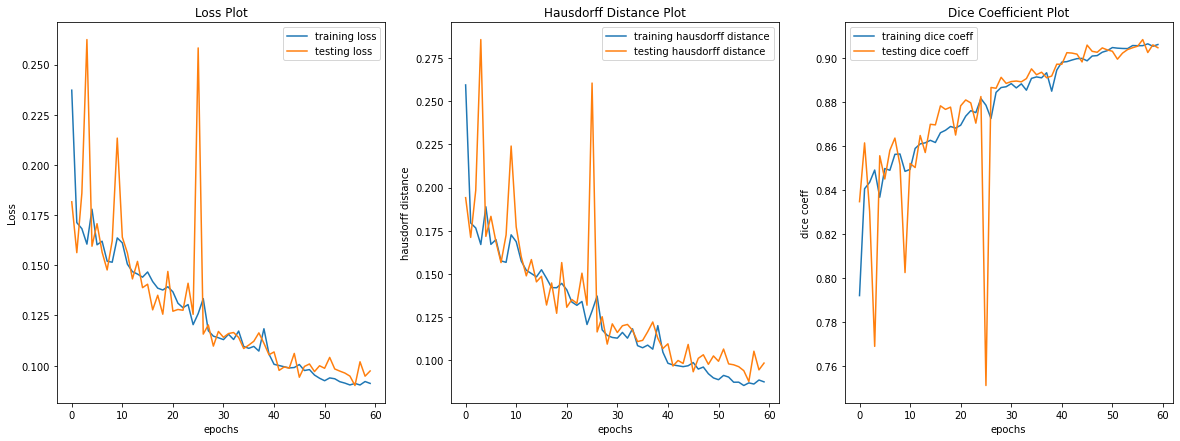

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

axs[0].plot(training_losses, label='training loss')
axs[0].plot(testing_losses, label='testing loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss Plot')
axs[0].legend()

axs[1].plot(training_hds, label='training hausdorff distance')
axs[1].plot(testing_hds, label='testing hausdorff distance')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('hausdorff distance')
axs[1].set_title('Hausdorff Distance Plot')
axs[1].legend()

axs[2].plot(training_dice_coeffs, label='training dice coeff')
axs[2].plot(testing_dice_coeffs, label='testing dice coeff')
axs[2].set_xlabel('epochs')
axs[2].set_ylabel('dice coeff')
axs[2].set_title('Dice Coefficient Plot')
axs[2].legend()

## Model Testing on Non-augmented Data

In [45]:
best_model_path = './model_params/tumor_segmentation_params.pth.tar' 
best_model_state = torch.load(best_model_path)['segmentation_net_params']

pipeline.model.load_state_dict(best_model_state)

eval_loss, eval_hd, eval_dice_coeff = pipeline.test(eval_dataloader, verbose=True)

50it [00:21,  2.28it/s]


 Testing Loss: 0.06821778446735441  
Test Dice Coeff: 0.935388239622116 
Test Hausdorff Distance: 0.07127705863518742


## Visualising Model Predictions

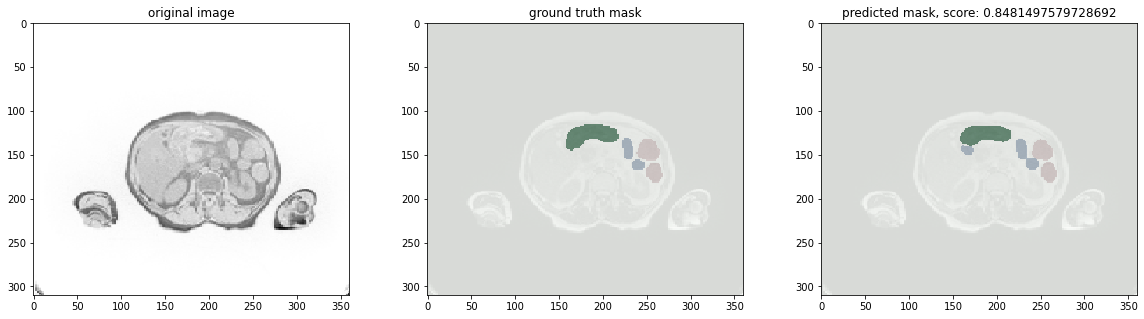

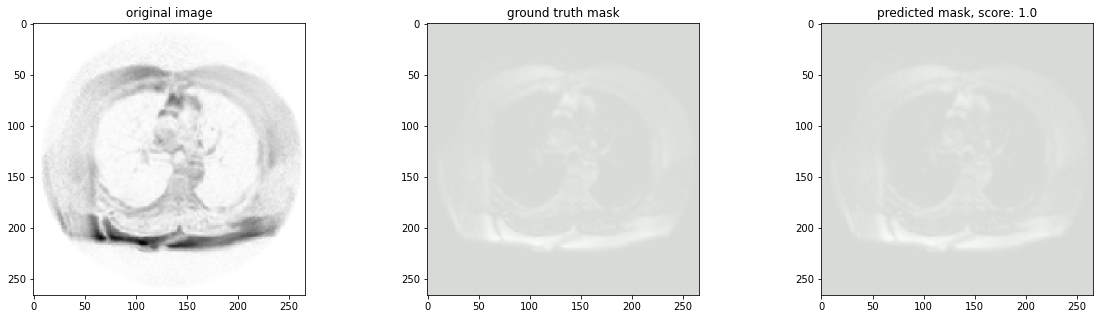

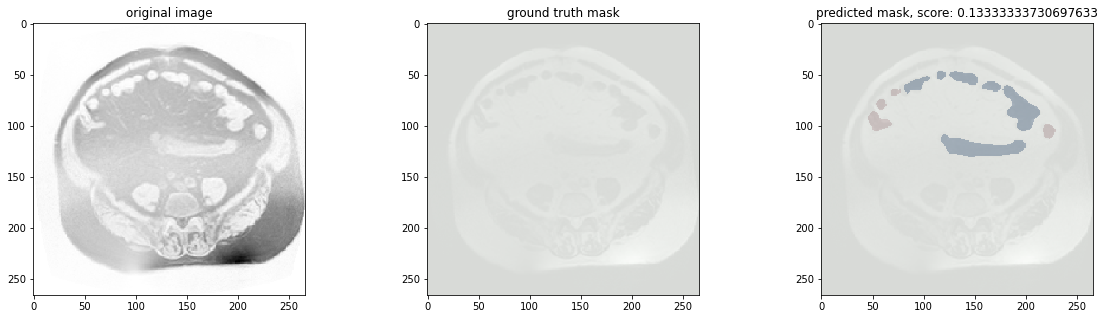

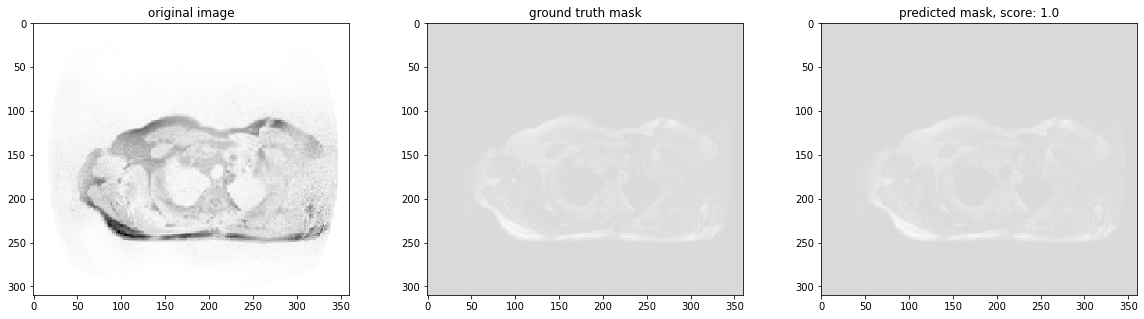

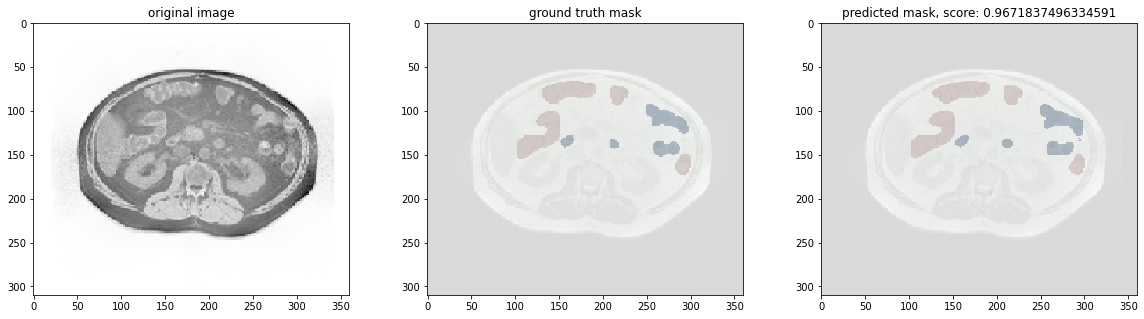

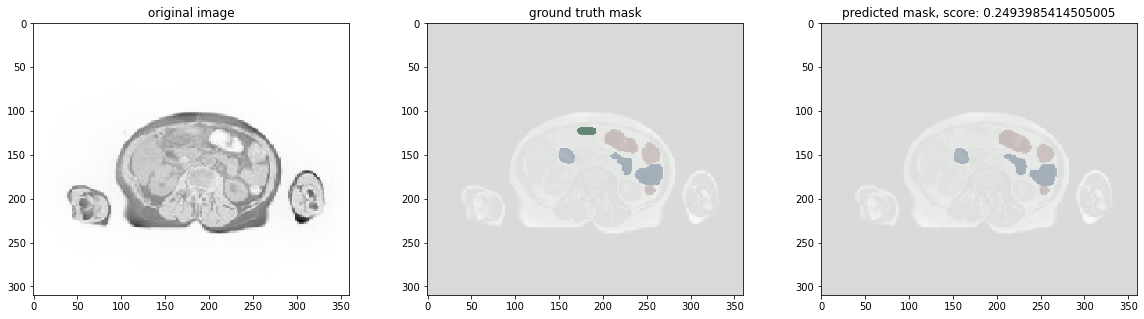

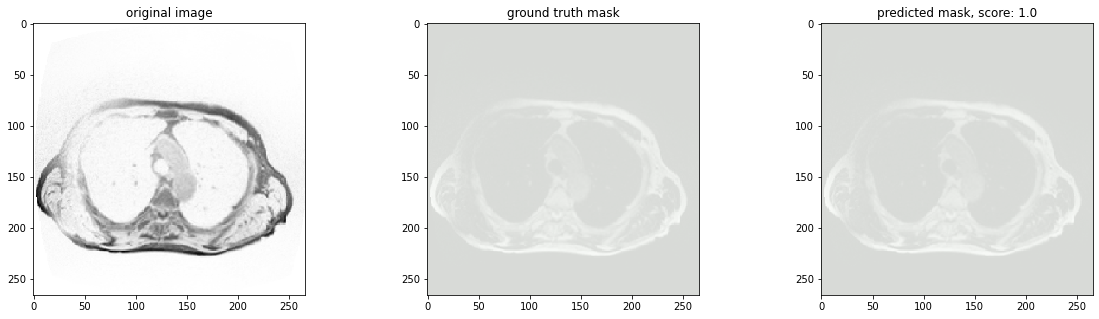

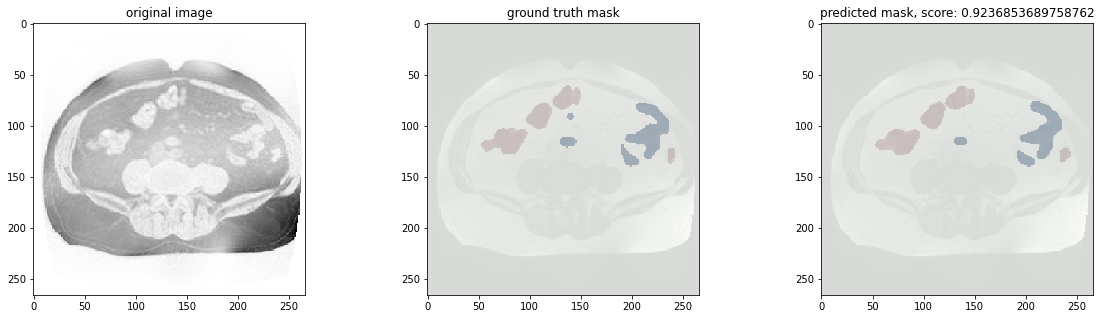

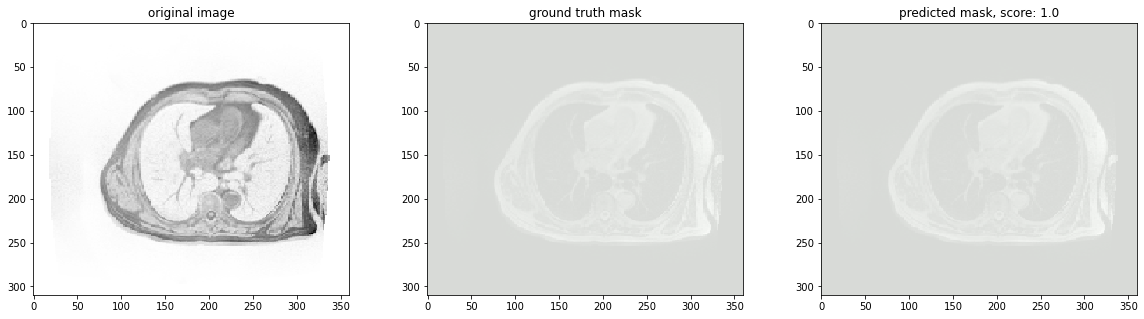

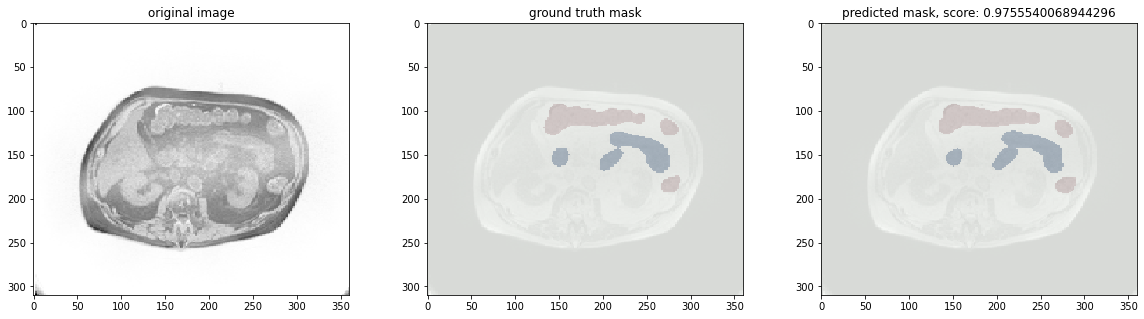

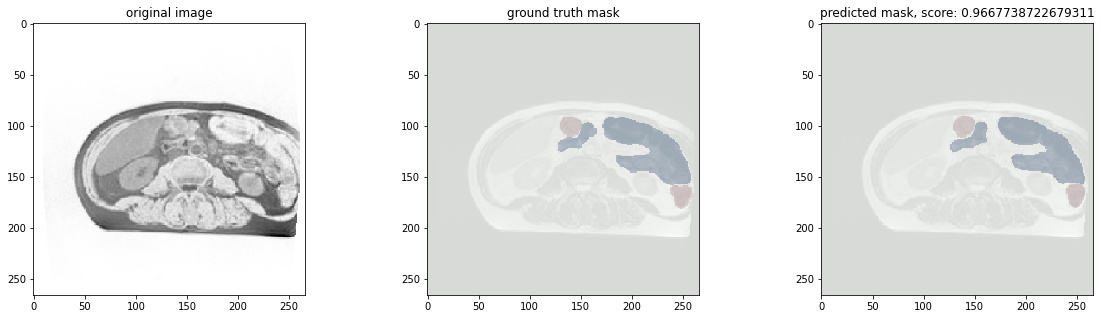

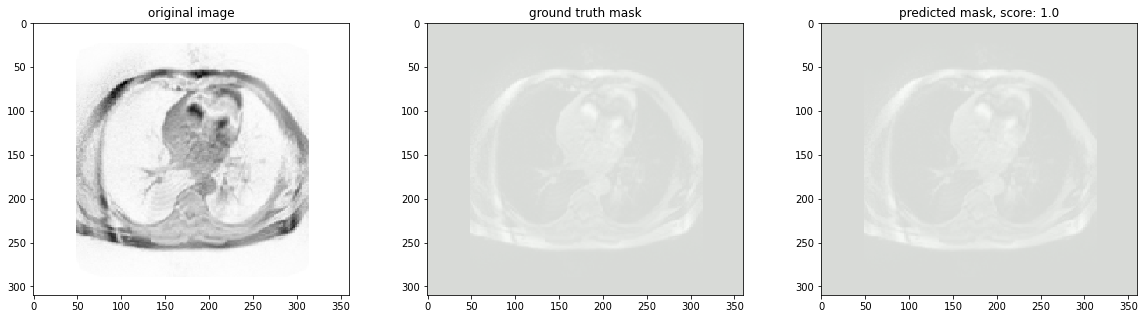

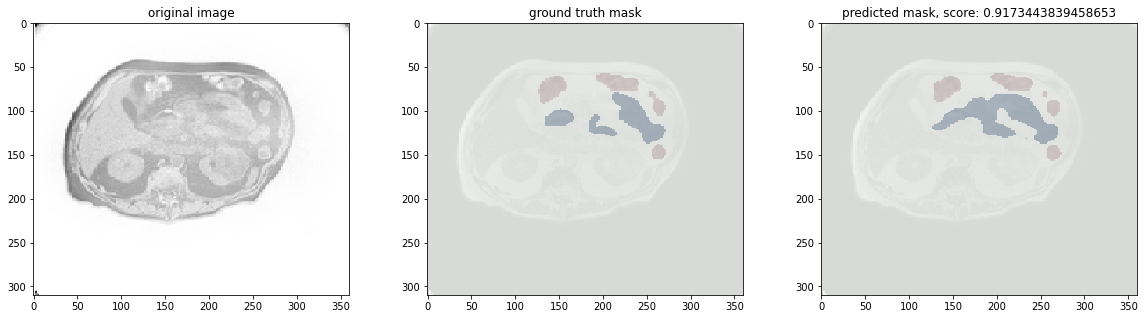

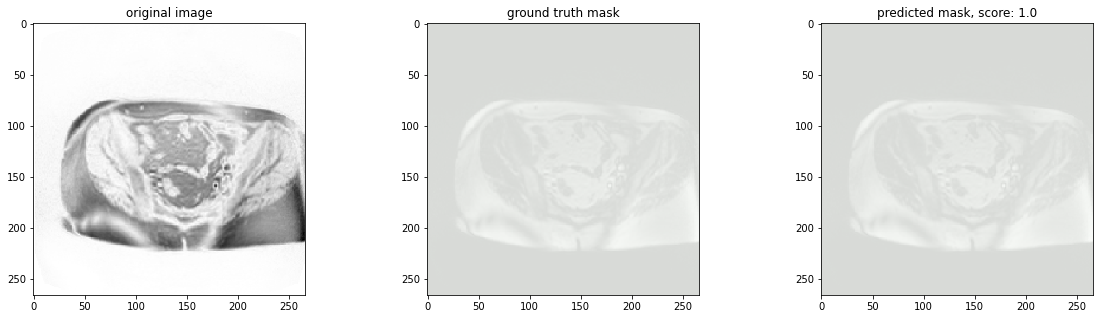

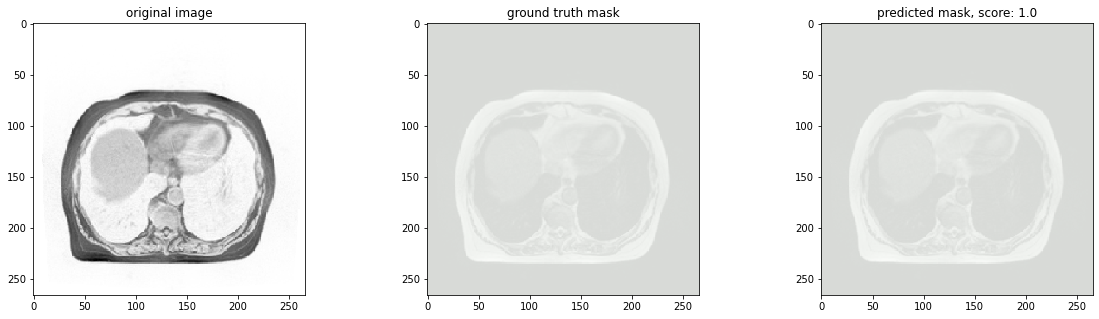

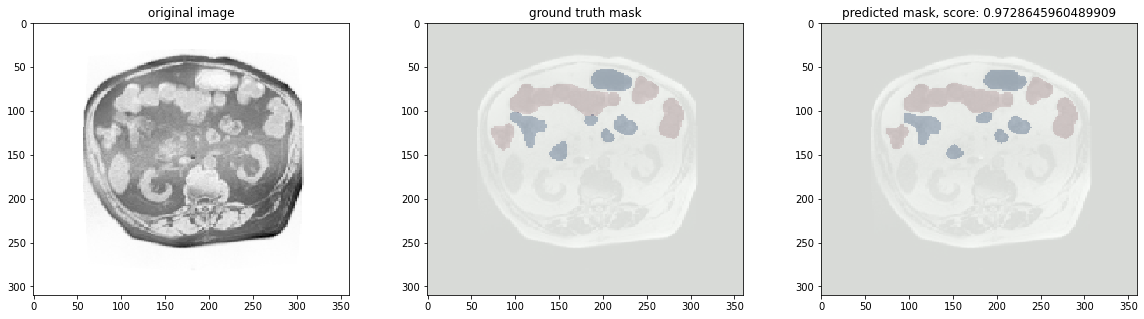

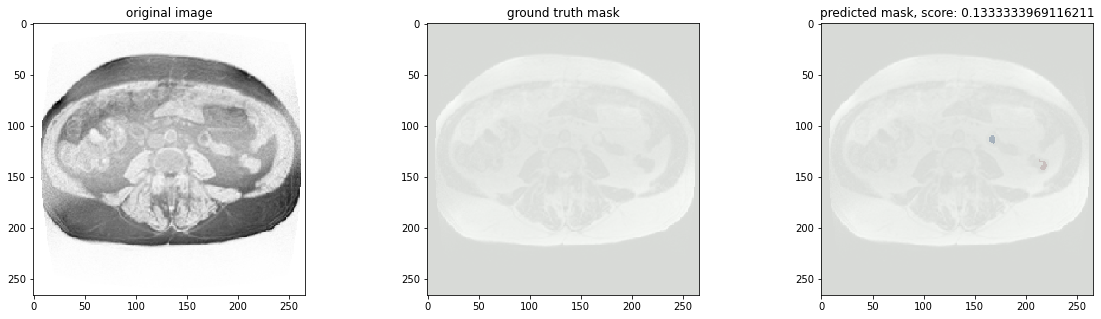

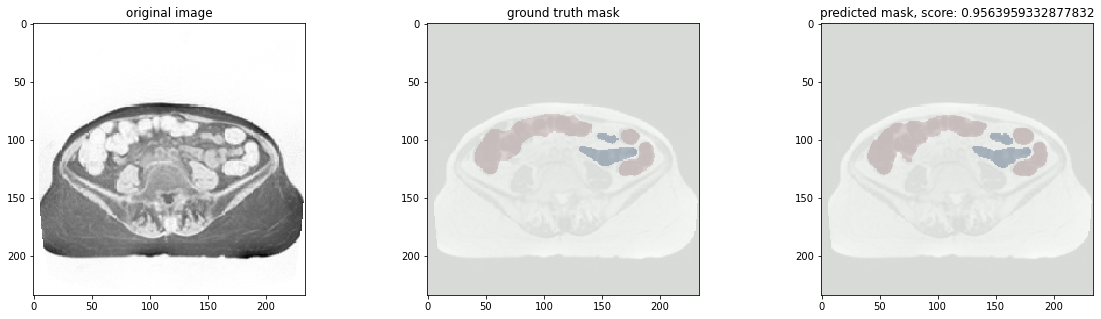

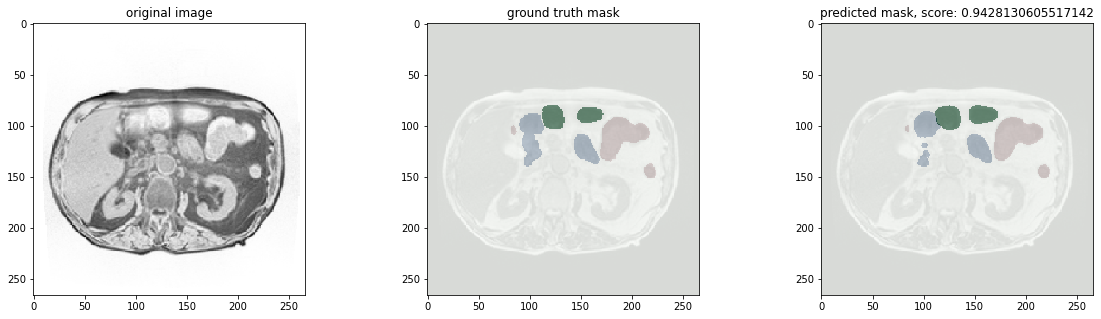

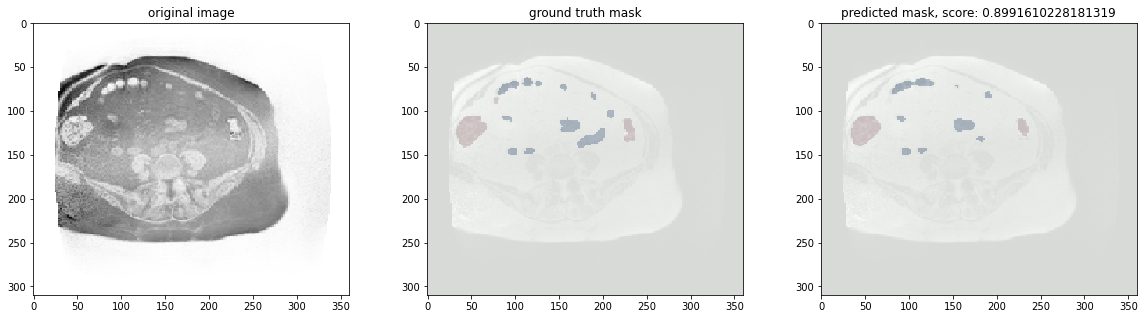

In [46]:
rand_idx = np.random.randint(0, len(eval_data)-1, 20)

for i in rand_idx:
    h, w = eval_data_df.height[i], eval_data_df.width[i]
    
    image, gt_mask = eval_data[i]

    gt_mask = gt_mask.unsqueeze(dim=0)

    eval_sample = image.unsqueeze(dim=0).to(device)
    pred_mask = pipeline.model(eval_sample)

    #resize tensors appropriately
    image = image_resize(image, (h, w))
    gt_mask = image_resize(gt_mask, (h, w))
    pred_mask = image_resize(pred_mask, (h, w))

    #print(pred_mask.shape, gt_mask.shape)
    dice_score = pipeline.lossfunc.dice_coeff(pred_mask, gt_mask)

    hd = pipeline.lossfunc.hausdorff_distance(pred_mask, gt_mask)

    pred_score = (0.6 * (1 - hd)) + (0.4 * dice_score)

    gt_mask = gt_mask.squeeze()
    pred_mask = pred_mask.squeeze().round().detach().cpu()

    lb_gt_mask, sb_gt_mask, stomach_gt_mask = gt_mask
    lb_pred_mask, sb_pred_mask, stomach_pred_mask = pred_mask

    alpha = 0.5

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].imshow(image.squeeze(), cmap='gray', interpolation='none')
    axs[0].set_title('original image')

    axs[1].imshow(image.squeeze(), cmap='Greys', interpolation='none')
    axs[1].imshow(lb_gt_mask, cmap='Reds', alpha=alpha, interpolation='none')
    axs[1].imshow(sb_gt_mask, cmap='Blues', alpha=alpha, interpolation='none')
    axs[1].imshow(stomach_gt_mask, cmap='Greens', alpha=alpha, interpolation='none')
    axs[1].set_title('ground truth mask')

    axs[2].imshow(image.squeeze(), cmap='Greys', interpolation='none')
    axs[2].imshow(lb_pred_mask, cmap='Reds', alpha=alpha, interpolation='none')
    axs[2].imshow(sb_pred_mask, cmap='Blues', alpha=alpha, interpolation='none')
    axs[2].imshow(stomach_pred_mask, cmap='Greens', alpha=alpha, interpolation='none')
    axs[2].set_title(f'predicted mask, score: {pred_score}')